### Introduction

Sentiment Analysis refers to a natural language processing technique used to determine whether the feelings expressed in a piece of text, are positive, negative or neutral. Its uses include the monitoring of customer feedback in order to improve customer relationships, as well as to inform decisions as it relates to products, brands or services being offered by a company. The purpose of this project is to perform sentiment analysis on a sample of Amazon customer reviews. 

First, we will design and implement twelve different sentiment classification models. 

These models will then be evaluated on unseen data, using a number of different evaluation metrics.

After training and evaluating all the models, we will compare the metrics for each model, then decide which would be best models to explore further for this type of classification task.

The aim is to build a model capable of distinguishing between, positive, negative and neutral reviews, with a high degree of accuracy, even in cases where one or more of the review classes rarely occur.

We are constrained to use the F1 score as the primary metric for choosing the best model. Insights, however, will be drawn using other metrics where their use is deemed to be more informative than just F1 score.

Finally, we will attempt to perform topic modeling on the dataset in an effort to segment the various issues being discussed throught the reviews.

In [1]:
from numpy.random import seed
seed(100)
from tensorflow.compat.v1 import set_random_seed
set_random_seed(200)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings("ignore")


## Data Importation and Basic Exploratory Data Analysis

In [2]:
train_file = 'Ecommerce/train_data.csv'
test_file = 'Ecommerce/test_data.csv'

In [3]:
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

In [4]:
train_df.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-26T00:00:00.000Z,Purchased on Black FridayPros - Great Price (e...,Powerful tablet,Positive
1,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-17T00:00:00.000Z,I purchased two Amazon in Echo Plus and two do...,Amazon Echo Plus AWESOME,Positive
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-20T00:00:00.000Z,Just an average Alexa option. Does show a few ...,Average,Neutral
3,"Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 ...",Amazon,"eBook Readers,Fire Tablets,Electronics Feature...","Office Supplies,Electronics",2017-08-04T00:00:00.000Z,"very good product. Exactly what I wanted, and ...",Greattttttt,Positive
4,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-01-23T00:00:00.000Z,This is the 3rd one I've purchased. I've bough...,Very durable!,Positive


In [5]:
test_df.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title
0,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...",Amazon,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,2016-05-23T00:00:00.000Z,Amazon kindle fire has a lot of free app and c...,very handy device
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-01-02T00:00:00.000Z,The Echo Show is a great addition to the Amazo...,Another winner from Amazon
2,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-02T00:00:00.000Z,Great value from Best Buy. Bought at Christmas...,simple to use and reliable so far
3,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-03-25T00:00:00.000Z,"I use mine for email, Facebook ,games and to g...",Love it!!!
4,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2017-11-15T00:00:00.000Z,This is a fantastic item & the person I bought...,Fantastic!


In [6]:
print(train_df.shape, test_df.shape)
#The train data has an an extra column when compared to the test data.
#This column must be the target variable column.

(4000, 8) (1000, 7)


In [7]:
print("The target labels are in the {} column.".format([col for col in train_df.columns if col not in test_df.columns][0]))

The target labels are in the sentiment column.


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               4000 non-null   object
 1   brand              4000 non-null   object
 2   categories         4000 non-null   object
 3   primaryCategories  4000 non-null   object
 4   reviews.date       4000 non-null   object
 5   reviews.text       4000 non-null   object
 6   reviews.title      3990 non-null   object
 7   sentiment          4000 non-null   object
dtypes: object(8)
memory usage: 250.1+ KB


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               1000 non-null   object
 1   brand              1000 non-null   object
 2   categories         1000 non-null   object
 3   primaryCategories  1000 non-null   object
 4   reviews.date       1000 non-null   object
 5   reviews.text       1000 non-null   object
 6   reviews.title      997 non-null    object
dtypes: object(7)
memory usage: 54.8+ KB


`With the exception of the reviews.title column, there are no missing data in the dataset. More importantly, there are no missing data in the 'reviews.text' column (from which we will extract our training features), or the sentiment column, which contains the target values.`

### Dropping duplicated values from our training data

In [10]:
train_df = train_df.drop_duplicates()
train_df.shape
#There were 58 ducplicated entries in the training data.

(3942, 8)

### Analysis of the target variable

In [11]:
train_df.sentiment.value_counts(normalize=True)
#93.71% of the training examples belong to the 'Positive' class
#4.01% of the training examples belong to the 'Neutral' class
#2.28% of the training examples belong to the 'Negative' class.

Positive    0.937088
Neutral     0.040081
Negative    0.022831
Name: sentiment, dtype: float64

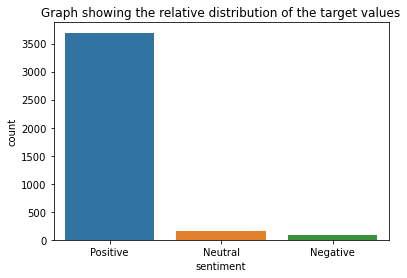

In [12]:
sns.countplot(data=train_df, x='sentiment')
plt.title('Graph showing the relative distribution of the target values')
plt.show()



`It is quite easy to see that this problem is one with highly imbalanced classes.`

**Examples of positive, negative, and neutral reviews**

In [13]:
positive_sents = train_df.sentiment == 'Positive'
#The series above has True values in positions where the sentiment value is positive.
negative_sents = train_df.sentiment == 'Negative'
#The series above has True values in positions where the sentiment value is negative.
neutral_sents = train_df.sentiment == 'Neutral'
#The series above has True values in positions where the sentiment value is neutral.

In [14]:
positive_sents.head()


0     True
1     True
2    False
3     True
4     True
Name: sentiment, dtype: bool

In [15]:
first_2_pos_reviews = train_df['reviews.text'][positive_sents].head(2).values
for review in first_2_pos_reviews:
    print(review, '\n')
#Printed below are the first two examples of positive reviews in the dataset.

Purchased on Black FridayPros - Great Price (even off sale)Very powerful and fast with quad core processors Amazing soundWell builtCons -Amazon ads, Amazon need this to subsidize the tablet and will remove the adds if you pay them $15.Inability to access other apps except the ones from Amazon. There is a way which I was able to accomplish to add the Google Play storeNet this is a great tablet for the money 

I purchased two Amazon in Echo Plus and two dots plus four fire sticks and the hub Philips hue for lamp for the family at Christmas 2017. I‚Äôm so happy with these purchases and learning so much with Alexa. You can start your daily routine with Alexa and program it to whatever you would like to include news weather music horoscope ALSO you can start your day off with a compliment and I think is very important. Alexa gave me the BEST CHILI RECIPE I MEAN THE BEST it‚Äôs called Chili I. I want my husband to use Alexa to stay organized for business dates and reminders. This is the way 

In [16]:
first_2_neg_reviews = train_df['reviews.text'][negative_sents].head(2).values
for review in first_2_neg_reviews:
    print(review, '\n')
    
#Printed below are the first two examples of negative reviews in the dataset.

was cheap, can not run chrome stuff, returned to store. 

Worthless, except as a regular echo and a poor excuse for video chat. I love my echo devices, bathroom, pool, kitchen, other places where I may need hands free, voice activated music and info. My wife bought me the 'newest, hottest' thing. I was skeptical but then thought I would use it to help on a project. Me "Alexa find videos on f450 drone" Alexa "YouTube is not available". Amazon won't directly sell chrome products, youtube won't play on echo show. Further testing shows the video call is more limited than iPhone or Android apps for video. So the most useful thing now is the same voice functions that my echos and dots perform. Unless I want to make all of my video calls and check the weather from a device I can move no more than 3 feet from an outlet. 



In [17]:
first_2_neutral_reviews = train_df['reviews.text'][neutral_sents].head(2).values
for review in first_2_neutral_reviews:
    print(review, '\n')
    
#Printed below are the first two examples of neutral reviews in the dataset.

Just an average Alexa option. Does show a few things on screen but still limited. 

My 7-year old daughter saved up to by this. Her brother bought the 8GB about a year earlier, so new she needed more space. The OS is a bit clunky, and less intuitive then on higher priced tablets, but tough to beat the price. Speed isn't great for web or certain gaming apps, but fine for books. Parental controls are helpful, but take time to figure out and require more steps than seem necessary to change. Overall, OK first tablet for kids, considering the price. For adults, fine for e-books and VERY basic apps. Otherwise, best to pay up for better quality and OS efficiency. 



### Text Cleaning and  Feature Extraction using TfidfVectorizer

In [18]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
import spacy


In [19]:
spacy_nlp_model = spacy.load("en_core_web_sm")

#### Label encoding of the target labels

In [20]:
sentiments = train_df.sentiment
sentiments.head()

0    Positive
1    Positive
2     Neutral
3    Positive
4    Positive
Name: sentiment, dtype: object

In [21]:
le = LabelEncoder()
encoded_labels = le.fit_transform(sentiments)

In [22]:
le.classes_
#These are the values that were transformed by the LabelEncoder object

array(['Negative', 'Neutral', 'Positive'], dtype=object)

In [23]:
new_labels = np.unique(encoded_labels)
new_labels
#The new labels are either 0, 1 or 2 instead of negative, neutral and positive

array([0, 1, 2])

In [24]:
le.inverse_transform(new_labels)
#The .inverse_transform() function confirms the mappings
    #0: negative, 1: neutral, 2: positive

array(['Negative', 'Neutral', 'Positive'], dtype=object)

### Text Cleaning and  Feature Extraction using TfidfVectorizer (continued)

In [25]:
s_words = stopwords.words('english')


In [26]:
reviews = train_df['reviews.text']

In [27]:
reviews

0       Purchased on Black FridayPros - Great Price (e...
1       I purchased two Amazon in Echo Plus and two do...
2       Just an average Alexa option. Does show a few ...
3       very good product. Exactly what I wanted, and ...
4       This is the 3rd one I've purchased. I've bough...
                              ...                        
3995    It‚Äôs fun for the family to play with, but it...
3996    I love the Kindle, it is a great product. It r...
3997    I was looking for a blutooth speaker to use wi...
3998    This is the second Amazon Fire 7 tablet I have...
3999    very satisfied with tablet, very fast and effi...
Name: reviews.text, Length: 3942, dtype: object

In [28]:
def text_cleaner(doc):
    """
    This function takes a single document / piece of text.
    It performs, tokenization, lemmatization and removes punctuations and stop words.
    """
    doc = doc.lower()
    tokens = nltk.word_tokenize(doc)
    tokens = [word for word in tokens if word not in s_words and word.isalpha()]
    doc = ' '.join(tokens)
    spacy_doc = spacy_nlp_model(doc)
    tokens = [word.lemma_ for word in spacy_doc]
    doc = " ".join(tokens)
    
    return doc

In [29]:
doc1 = reviews.iloc[4]
doc1
#This is an example of a document before text cleaning.

"This is the 3rd one I've purchased. I've bought one for all of my nieces. No other case compares to this one. It has held protected the tablet so many times from them dropping it."

In [30]:
text_cleaner(doc1)
#This is a test of the text cleaner function.
#stopwords and punctuations have been removed
#words have been lemmatized(reduced to base form), eg. dropping -> drop, nieces -> niece

'one purchase buy one niece case compare one hold protect tablet many time drop'

In [31]:
cleaned_reviews = reviews.apply(text_cleaner)

In [32]:
cleaned_reviews.head()

0    purchase black fridaypro great price even sale...
1    purchase two amazon echo plus two dot plus fou...
2    average alexa option show thing screen still l...
3                 good product exactly want good price
4    one purchase buy one niece case compare one ho...
Name: reviews.text, dtype: object

In [33]:
X_train, X_test, y_train, y_test = train_test_split(cleaned_reviews, encoded_labels, test_size=0.15,
                                                   stratify=encoded_labels, random_state=100)

In [34]:
X_train.head()

3081    think download new app wait surf web thing slo...
1775    purchase yr old love fact play game movie love...
3510    buy son size perfect small big kid friendly ea...
337       big good kindle yet light feather buy one today
3327                   granddaughter love use school work
Name: reviews.text, dtype: object

In [35]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(3350,) (3350,) (592,) (592,)


In [36]:
vectorizer = TfidfVectorizer()

In [37]:
X_train_matrix = vectorizer.fit_transform(X_train)

In [38]:
X_train_matrix.shape

(3350, 3373)

In [39]:
X_test_matrix = vectorizer.transform(X_test)

In [40]:
X_test_matrix.shape

(592, 3373)

**Model Building Using Naive Bayes Classifier**

In [41]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

In [42]:
models_dict = {}
#This dictionary will be used to store the various models.
#It will allow us to easily access and compare the test metrics for each model.
#The term test metrics refers to various metrics used to evaluate model performance on the test set.

In [43]:
binarizer = LabelBinarizer()
y_test_binary = binarizer.fit_transform(y_test)
#We will require binary labels in order to plot roc_curves for the various models.

In [44]:
y_test_binary

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [45]:
class MyMultinomialNB(MultinomialNB):
    def __init__(self, name, test_metrics={}):
        super().__init__()
        self.name = name
        self.test_metrics = test_metrics
        models_dict.update({self.name: self})

#By constructing custom classes, we will be able to assign custom test metrics to each model.
        

In [46]:
def print_scores(y_true, y_predicted):
    
    """
    This function will be used to print the recall, precision and f1 scores associated with each classifier's 
    performance on the training and test sets.
    """
    
    rs = recall_score(y_true, y_predicted, labels=[0, 1, 2], 
                           average=None, zero_division=0 )
    ps = precision_score(y_true, y_predicted, labels=[0, 1, 2], 
                           average=None, zero_division=0)
    fs = f1_score(y_true, y_predicted, labels=[0, 1, 2], 
                           average=None, zero_division=0)
    overall_f1 = f1_score(y_true, y_predicted, average = 'macro', zero_division=0)
    
    
    print('recall score:',rs) 
    print('precision score:', ps)
    print('f1 score', fs)
    print('average f1 score:', overall_f1)
      


In [47]:
def update_scores(model, y_true, y_predicted, y_probs):
    
    """
    This function takes a model, y_true, y_predicted and y_probs. It uses these variables, 
    along with various evaluation metrics, to evaluate the performance on the test set.
    It then associates these metrics with the model being evaluated, for us to compare the various models that were trained.
    """
    
    rs = recall_score(y_true, y_predicted, average='macro', zero_division=0)
    rs = round(rs, 3)
    ps = precision_score(y_true, y_predicted, average='macro', zero_division=0)
    ps = round(ps, 3)                       
    fs = f1_score(y_true, y_predicted, average='macro', zero_division=0)
    fs = round(fs, 4) 
    aucs = dict()
    thresholds = dict()
    for i in range(3):
        fpr, tpr, thresholds[i] = roc_curve(y_test_binary[:, i], y_probs[:, i])
        aucs[i] = round(auc(fpr, tpr), 3)
        
    calc_metrics = {"rs": rs, "ps": ps, "fs": fs, "aucs": aucs }
    
    model.test_metrics.update(calc_metrics)

In [48]:
def generate_test_metrics_df():
    
    """
    This function will be used to generate a DataFrame of models and the various metrics obtained by evaluating their
    perfomance on the test set.
    
    It will provide us with an fast and efficient way to compare various models.
    
    """

    test_metrics_df = pd.DataFrame([model.test_metrics for model in models_dict.values()], 
             index=models_dict.keys())
    test_metrics_df['auc_class0'] = test_metrics_df.aucs.apply(lambda x: x[0])
    test_metrics_df['auc_class1'] = test_metrics_df.aucs.apply(lambda x: x[1])
    test_metrics_df['auc_class2'] = test_metrics_df.aucs.apply(lambda x: x[2])
    test_metrics_df = test_metrics_df.drop('aucs', axis=1)
    
    return test_metrics_df

**Model Naming Convention**`

`Models will generally be named using a 3 or 4 letter word.
In the case where variants of a particular model is used, the variant will be identified by a prefix.`

In [49]:
mnb = MyMultinomialNB('mnb')

In [50]:
mnb.fit(X_train_matrix, y_train)

MyMultinomialNB(name='mnb')

In [51]:
mnbtrain_predictions = mnb.predict(X_train_matrix)
mnbtest_predictions = mnb.predict(X_test_matrix)
mnbtest_probs=mnb.predict_proba(X_test_matrix)

In [52]:
confusion_matrix(y_train, mnbtrain_predictions)
#As a result of the biasness of the datset towards class 2
    #All examples are predicted as belonging to class 2 (As being a positive review)
    #This model is severely underfitting as it is not even doing a go job on the training set.

array([[   0,    0,   77],
       [   0,    0,  134],
       [   0,    0, 3139]], dtype=int64)

In [53]:
print_scores(y_train, mnbtrain_predictions)
#The classifier has recalled all examples belonging to class 2.
#It has however failed to identify a singles instance of the class 0 or class 1.
#Since the recall score for class 0 and class 1 are both 0, The f1 score is 0 for both classes.
#Even thought the recall score for class 2 is 1, f1 score is 0.968 since the precision score
    #is less than 1, as some values predicted to be 2, are not actually 2.

recall score: [0. 0. 1.]
precision score: [0.         0.         0.93701493]
f1 score [0.         0.         0.96748343]
average f1 score: 0.3224944778342837


### The  ROC curves of the Multinomial Naive Bayes Classifier

In [54]:
def plot_roc_curves(probs, title):
    
    """
    This function will be used to plot roc curves in order to evaluate the various classifiers.
    
    """
    fpr = dict()
    tpr = dict()
    thresholds = dict()
    for i in range(3):
        fpr[i], tpr[i], thresholds[i] = roc_curve(y_test_binary[:, i], probs[:, i])
    cols = ['red', 'blue', 'green']
    plt.figure(figsize=(10, 8))
    for i in range(3):
        area_under_curve = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], color = cols[i], 
                label = 'ROC curve for class {0}. AUC = {1}'.format(i, area_under_curve))
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc=4)
    plt.show()

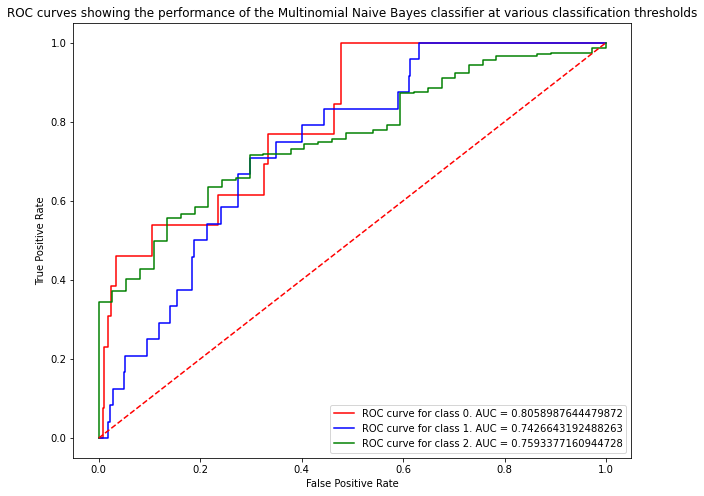

In [55]:
title = 'ROC curves showing the performance of the Multinomial Naive Bayes classifier at various classification thresholds'
plot_roc_curves(mnbtest_probs, title)

In [56]:
update_scores(mnb, y_test, mnbtest_predictions, mnbtest_probs)

In [57]:
mnb.test_metrics
#Below are the computed evaluation metrics for the classifier on the test set.

{'rs': 0.333,
 'ps': 0.312,
 'fs': 0.3226,
 'aucs': {0: 0.806, 1: 0.743, 2: 0.759}}

In [58]:
models_dict
#The models_dict dictionary shows the models we have trained so far.

{'mnb': MyMultinomialNB(name='mnb')}

In [59]:
generate_test_metrics_df()

,rs,ps,fs,auc_class0,auc_class1,auc_class2
mnb,0.333,0.312,0.3226,0.806,0.743,0.759


### Oversampling

Because of the very limited amount of data available for this project. Oversampling will be used to tackle the class imbalance problem.

In [60]:
from imblearn.over_sampling import SMOTE

In [61]:
resampler = SMOTE()

In [62]:
X_res, y_res = resampler.fit_resample(X_train_matrix, y_train)

In [63]:
print(X_res.shape, y_res.shape)

(9417, 3373) (9417,)


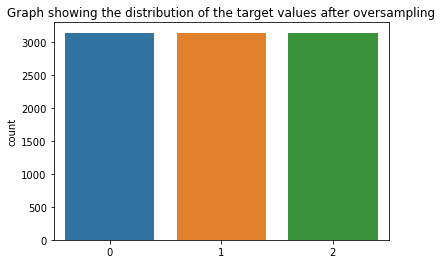

In [64]:
sns.countplot(x=y_res)
plt.title("Graph showing the distribution of the target values after oversampling")
plt.show()
#The classes are no longer imbalanced.

**Training a Naive Bayes Classifier on the resampled data**

In [65]:
class MyOversampledMultinomialNB(MultinomialNB):
    def __init__(self, name, test_metrics={}):
        super().__init__()
        self.name = name
        self.test_metrics = test_metrics
        models_dict.update({self.name: self})
        

In [66]:
oversampled_mnb = MyOversampledMultinomialNB('oversampled_mnb')

In [67]:
oversampled_mnb.fit(X_res, y_res)

MyOversampledMultinomialNB(name='oversampled_mnb')

In [68]:
oversampled_mnbtrain_predictions = oversampled_mnb.predict(X_res)
oversampled_mnbtest_predictions = oversampled_mnb.predict(X_test_matrix)
oversampled_mnbtest_probs = oversampled_mnb.predict_proba(X_test_matrix)

In [69]:
confusion_matrix(y_res, oversampled_mnbtrain_predictions)

array([[3139,    0,    0],
       [   0, 3113,   26],
       [  75,  207, 2857]], dtype=int64)

In [70]:
print_scores(y_res, oversampled_mnbtrain_predictions)

recall score: [1.         0.99171711 0.91016247]
precision score: [0.97666459 0.9376506  0.99098162]
f1 score [0.98819455 0.9639263  0.9488542 ]
average f1 score: 0.9669916864658847


`From what we observe from our confusion matrix, recall score, precision score, and f1 score; oversampling the minority classes allows our classifier to construct a decision function that is capable of separating the three classes in the training set. Precision, recall and f1 scores are all very high.`

`Oversampling, however, often leads to overfitting, so we must investigate the performance of the new classifier (trained on the oversampled dataset), on the test set.`

In [71]:
confusion_matrix(y_test, oversampled_mnbtest_predictions, labels=[0, 1, 2])

array([[  7,   1,   5],
       [  1,  16,   7],
       [ 22,  37, 496]], dtype=int64)

In [72]:
print_scores(y_test, oversampled_mnbtest_predictions)
#The classifier performs better on unseen data than the classifier trained on the imbalanced dataset.
    #average f1 score of (0.56) compared to (0.32)
#This classifier however performs way worse on the test set than it does on the training set.
#We will therefore try to find another model that will be able to generalize better to previously unseen data.

recall score: [0.53846154 0.66666667 0.89369369]
precision score: [0.23333333 0.2962963  0.97637795]
f1 score [0.3255814  0.41025641 0.9332079 ]
average f1 score: 0.5563485692563117


`Our observations indicate that the MultinomialNaiveBayes Classifier trained on a dataset with sythetic samples of the minority classes is capable of identifying those synthetic samples, but fails to generalize well to previously unseen data. `

### The  ROC curves of the Multinomial Naive Bayes Classifier trained with oversampled data

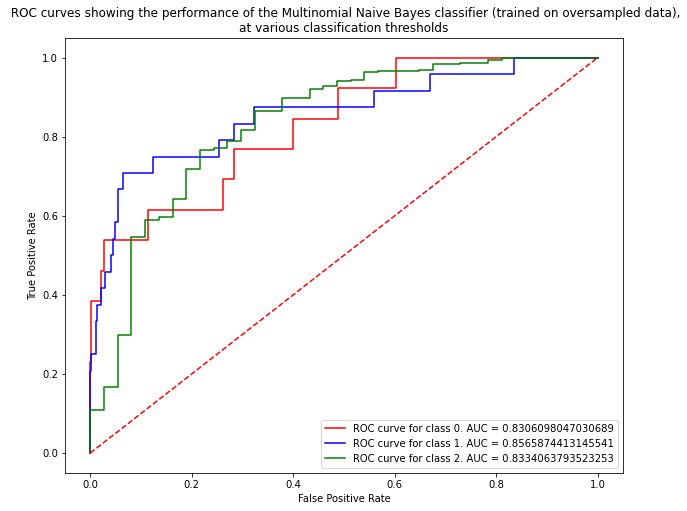

In [73]:
title = """ ROC curves showing the performance of the Multinomial Naive Bayes classifier (trained on oversampled data),
at various classification thresholds"""
plot_roc_curves(oversampled_mnbtest_probs, title)

In [74]:
update_scores(oversampled_mnb, y_test, oversampled_mnbtest_predictions, oversampled_mnbtest_probs)

In [75]:
oversampled_mnb.test_metrics

{'rs': 0.7, 'ps': 0.502, 'fs': 0.5563, 'aucs': {0: 0.831, 1: 0.857, 2: 0.833}}

In [76]:
models_dict

{'mnb': MyMultinomialNB(name='mnb'),
 'oversampled_mnb': MyOversampledMultinomialNB(name='oversampled_mnb')}

In [77]:
generate_test_metrics_df()

,rs,ps,fs,auc_class0,auc_class1,auc_class2
mnb,0.333,0.312,0.3226,0.806,0.743,0.759
oversampled_mnb,0.700,0.502,0.5563,0.831,0.857,0.833


`The table above shows that training the MultinomialNB classifier using synthetic samples, significantly improves the performace of the classifier on the test set. Every metric indicates better performance.` 

### Ramdom Forest Classifier

In [78]:
from sklearn.ensemble import RandomForestClassifier

In [79]:
class MyRandomForestClassifier(RandomForestClassifier):
    def __init__(self, name, test_metrics={}):
        super().__init__(random_state=100)
        self.name = name
        self.test_metrics = test_metrics
        models_dict.update({self.name: self})

In [80]:
rfc = MyRandomForestClassifier("rfc")

In [81]:
rfc.fit(X_train_matrix, y_train)

MyRandomForestClassifier(name='rfc')

In [82]:
rfctrain_predictions = rfc.predict(X_train_matrix)
rfctest_predictions = rfc.predict(X_test_matrix)
rfctest_probs = rfc.predict_proba(X_test_matrix)


In [83]:
confusion_matrix(y_train, rfctrain_predictions)
#The FandomForestClassifier algorithm with class_weight parameter = 'balanced' is capable of perfectly
    #classifying the training data.

array([[  77,    0,    0],
       [   0,  134,    0],
       [   0,    0, 3139]], dtype=int64)

In [84]:
print_scores(y_train, rfctrain_predictions)
#The rfc classifier is perfect at predicting the labels of examples it has seen before.

recall score: [1. 1. 1.]
precision score: [1. 1. 1.]
f1 score [1. 1. 1.]
average f1 score: 1.0


In [85]:
confusion_matrix(y_test, rfctest_predictions)

array([[  4,   0,   9],
       [  0,   5,  19],
       [  0,   0, 555]], dtype=int64)

In [86]:
print_scores(y_test, rfctest_predictions)


recall score: [0.30769231 0.20833333 1.        ]
precision score: [1.         1.         0.95197256]
f1 score [0.47058824 0.34482759 0.97539543]
average f1 score: 0.5969370840269931


### The  ROC curves of the Random Forest Classifier (class weight='balanced')

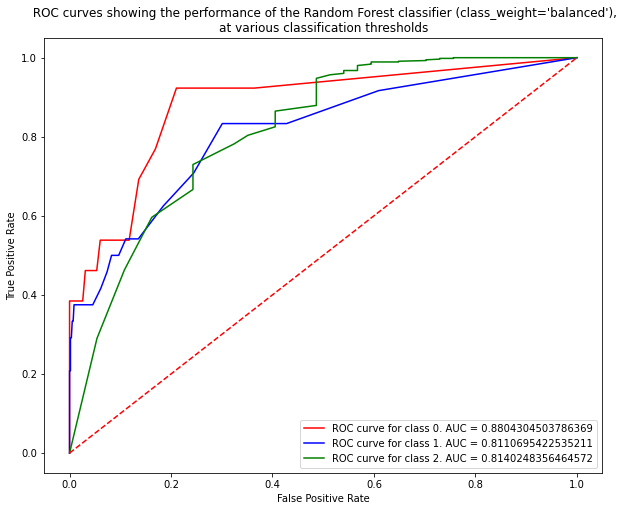

In [87]:
title = """ ROC curves showing the performance of the Random Forest classifier (class_weight='balanced'),
at various classification thresholds"""
plot_roc_curves(rfctest_probs, title)

In [88]:
update_scores(rfc, y_test, rfctest_predictions, rfctest_probs)


In [89]:
rfc.test_metrics

{'rs': 0.505, 'ps': 0.984, 'fs': 0.5969, 'aucs': {0: 0.88, 1: 0.811, 2: 0.814}}

In [90]:
models_dict

{'mnb': MyMultinomialNB(name='mnb'),
 'oversampled_mnb': MyOversampledMultinomialNB(name='oversampled_mnb'),
 'rfc': MyRandomForestClassifier(name='rfc')}

In [91]:
generate_test_metrics_df()

,rs,ps,fs,auc_class0,auc_class1,auc_class2
mnb,0.333,0.312,0.3226,0.806,0.743,0.759
oversampled_mnb,0.700,0.502,0.5563,0.831,0.857,0.833
rfc,0.505,0.984,0.5969,0.880,0.811,0.814


`The rf model gives better averafe f1 score on unseen data than the NaiveBayes model trained on synthetic samples.
It still does a poor job identifying examples from the minority classes, however.
Its recall score is significantly less than the recall score of the MultinomialNB classifier trained on synthetic samples.
It has a very high precision score though, all samples predicted as belonging to class 0 or 1, did in fact belong to those classes.`

### XGBoost

In [92]:
import xgboost as xgb
from xgboost import XGBClassifier


In [93]:
class MyXGBClassifier(XGBClassifier):
    def __init__(self, name, test_metrics={}):
        super().__init__(use_label_encoder=False ,random_state=100)
        self.name = name
        self.test_metrics = test_metrics
        models_dict.update({self.name: self})

In [94]:
xgb = MyXGBClassifier('xgb')

In [95]:
xgb.fit(X_train_matrix, y_train,)

[07:25:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "name", "test_metrics" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:25:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


MyXGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=1,
                enable_categorical=False, gamma=0, gpu_id=-1,
                importance_type=None, interaction_constraints='',
                learning_rate=0.300000012, max_delta_step=0, max_depth=6,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=100, n_jobs=8, name='xgb', num_parallel_tree=1,
                objective='multi:softprob', predictor='auto', random_state=100,
                reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
                tree_method='exact', use_label_encoder=False,
                validate_parameters=1, ...)

In [96]:
xgbtrain_predicitons = xgb.predict(X_train_matrix)
xgbtest_predictions = xgb.predict(X_test_matrix)
xgbtest_probs = xgb.predict_proba(X_test_matrix)

In [97]:
confusion_matrix(y_train, xgbtrain_predicitons)

array([[  76,    0,    1],
       [   0,  113,   21],
       [   0,    0, 3139]], dtype=int64)

In [98]:
print_scores(y_train, xgbtrain_predicitons)
#Even with the imbalanced classes, XGBoost is very capable of learning a good decision boundrary,
    #that separate the classes in the training set.

recall score: [0.98701299 0.84328358 1.        ]
precision score: [1.         1.         0.99304018]
f1 score [0.99346405 0.91497976 0.99650794]
average f1 score: 0.9683172486268461


In [99]:
confusion_matrix(y_test, xgbtest_predictions)

array([[  4,   0,   9],
       [  1,   8,  15],
       [  1,   1, 553]], dtype=int64)

In [100]:
print_scores(y_test, xgbtest_predictions)
#XGBClassifier also overfits to the training data.

recall score: [0.30769231 0.33333333 0.9963964 ]
precision score: [0.66666667 0.88888889 0.95840555]
f1 score [0.42105263 0.48484848 0.9770318 ]
average f1 score: 0.6276443061825245


### The  ROC curves of the XGB classifier

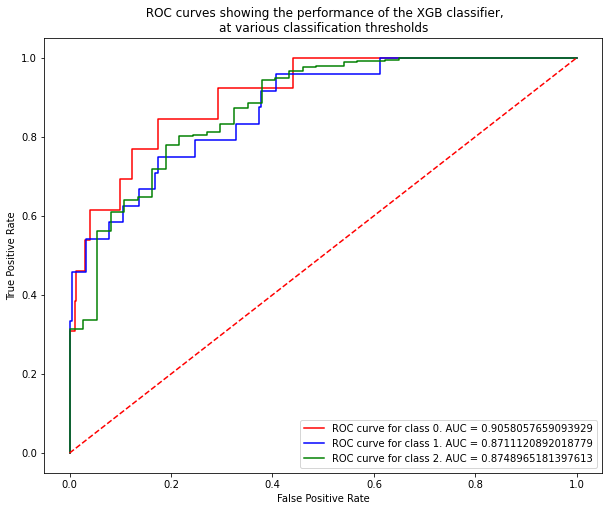

In [101]:
title = """ ROC curves showing the performance of the XGB classifier,
at various classification thresholds"""
plot_roc_curves(xgbtest_probs, title)

In [102]:
update_scores(xgb, y_test, xgbtest_predictions, xgbtest_probs)

In [103]:
xgb.test_metrics

{'rs': 0.546,
 'ps': 0.838,
 'fs': 0.6276,
 'aucs': {0: 0.906, 1: 0.871, 2: 0.875}}

In [104]:
models_dict

{'mnb': MyMultinomialNB(name='mnb'),
 'oversampled_mnb': MyOversampledMultinomialNB(name='oversampled_mnb'),
 'rfc': MyRandomForestClassifier(name='rfc'),
 'xgb': MyXGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bynode=1, colsample_bytree=1,
                 enable_categorical=False, gamma=0, gpu_id=-1,
                 importance_type=None, interaction_constraints='',
                 learning_rate=0.300000012, max_delta_step=0, max_depth=6,
                 min_child_weight=1, missing=nan, monotone_constraints='()',
                 n_estimators=100, n_jobs=8, name='xgb', num_parallel_tree=1,
                 objective='multi:softprob', predictor='auto', random_state=100,
                 reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
                 tree_method='exact', use_label_encoder=False,
                 validate_parameters=1, ...)}

In [105]:
generate_test_metrics_df()

,rs,ps,fs,auc_class0,auc_class1,auc_class2
mnb,0.333,0.312,0.3226,0.806,0.743,0.759
oversampled_mnb,0.700,0.502,0.5563,0.831,0.857,0.833
rfc,0.505,0.984,0.5969,0.880,0.811,0.814
xgb,0.546,0.838,0.6276,0.906,0.871,0.875


`Of the models covered so far, the XGB classifier performs the best as it relates to the average f1 score.
It does a better job of recalling samples of the minority class than the rfc classifier, but not as good as the MultinomialNB classifier.
Wheras its precision is not as high as the Random Forest classifier it gives much better values than the oversampled Multinomial NB model.
Another point worth noting is the auc score for class 0. The XGB has the highest area indicating that, if we are concerned with identifying as many negative reviews as possible, while minimizing the non - negative reviews that will be classified as negative, it would be the classifier of choice.`

### XGB with Oversampling

In [106]:
class MyOversampledXGBClassifier(XGBClassifier):   
    def __init__(self, name, test_metrics={}):
        super().__init__(use_label_encoder=False ,random_state=100)
        self.name = name
        self.test_metrics = test_metrics
        models_dict.update({self.name: self})

In [107]:
oversampled_xgb = MyOversampledXGBClassifier("oversampled_xgb")

In [108]:
oversampled_xgb.fit(X_res, y_res)

[07:25:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "name", "test_metrics" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:25:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


MyOversampledXGBClassifier(base_score=0.5, booster='gbtree',
                           colsample_bylevel=1, colsample_bynode=1,
                           colsample_bytree=1, enable_categorical=False,
                           gamma=0, gpu_id=-1, importance_type=None,
                           interaction_constraints='',
                           learning_rate=0.300000012, max_delta_step=0,
                           max_depth=6, min_child_weight=1, missing=nan,
                           monotone_constraints='()', n_estimators=100,
                           n_jobs=8, name='oversampled_xgb',
                           num_parallel_tree=1, objective='multi:softprob',
                           predictor='auto', random_state=100, reg_alpha=0,
                           reg_lambda=1, scale_pos_weight=None, subsample=1,
                           tree_method='exact', use_label_encoder=False,
                           validate_parameters=1, ...)

In [109]:
oversampled_xgbtrain_predictions = oversampled_xgb.predict(X_res)
oversampled_xgbtest_predictions = oversampled_xgb.predict(X_test_matrix)
oversampled_xgbtest_probs = oversampled_xgb.predict_proba(X_test_matrix)

In [110]:
confusion_matrix(y_res, oversampled_xgbtrain_predictions)

array([[3138,    0,    1],
       [   0, 3113,   26],
       [   0,    0, 3139]], dtype=int64)

In [111]:
print_scores(y_res, oversampled_xgbtrain_predictions)

recall score: [0.99968143 0.99171711 1.        ]
precision score: [1.         1.         0.99147189]
f1 score [0.99984069 0.99584133 0.99571768]
average f1 score: 0.9971332344594969


In [112]:
confusion_matrix(y_test,oversampled_xgbtest_predictions)

array([[  4,   0,   9],
       [  2,   6,  16],
       [  1,  13, 541]], dtype=int64)

In [113]:
print_scores(y_test, oversampled_xgbtest_predictions)

recall score: [0.30769231 0.25       0.97477477]
precision score: [0.57142857 0.31578947 0.95583039]
f1 score [0.4        0.27906977 0.96520963]
average f1 score: 0.5480931338989966


### The  ROC curves of the XGB classifier (trained with synthetic samples)

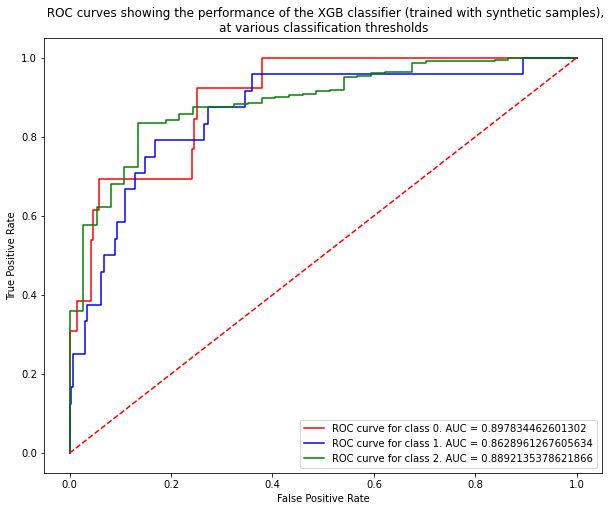

In [114]:
title = """ ROC curves showing the performance of the XGB classifier (trained with synthetic samples),
at various classification thresholds"""
plot_roc_curves(oversampled_xgbtest_probs, title)

In [115]:
update_scores(oversampled_xgb, y_test, oversampled_xgbtest_predictions, oversampled_xgbtest_probs)

In [116]:
oversampled_xgb.test_metrics

{'rs': 0.511,
 'ps': 0.614,
 'fs': 0.5481,
 'aucs': {0: 0.898, 1: 0.863, 2: 0.889}}

In [117]:
models_dict

{'mnb': MyMultinomialNB(name='mnb'),
 'oversampled_mnb': MyOversampledMultinomialNB(name='oversampled_mnb'),
 'rfc': MyRandomForestClassifier(name='rfc'),
 'xgb': MyXGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bynode=1, colsample_bytree=1,
                 enable_categorical=False, gamma=0, gpu_id=-1,
                 importance_type=None, interaction_constraints='',
                 learning_rate=0.300000012, max_delta_step=0, max_depth=6,
                 min_child_weight=1, missing=nan, monotone_constraints='()',
                 n_estimators=100, n_jobs=8, name='xgb', num_parallel_tree=1,
                 objective='multi:softprob', predictor='auto', random_state=100,
                 reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
                 tree_method='exact', use_label_encoder=False,
                 validate_parameters=1, ...),
 'oversampled_xgb': MyOversampledXGBClassifier(base_score=0.5, booster='gbtree'

In [118]:
generate_test_metrics_df()

,rs,ps,fs,auc_class0,auc_class1,auc_class2
mnb,0.333,0.312,0.3226,0.806,0.743,0.759
oversampled_mnb,0.700,0.502,0.5563,0.831,0.857,0.833
rfc,0.505,0.984,0.5969,0.880,0.811,0.814
xgb,0.546,0.838,0.6276,0.906,0.871,0.875
oversampled_xgb,0.511,0.614,0.5481,0.898,0.863,0.889


`The XGB classifier trained with synthetic samples does not perform as well as the one trained on the imbalanced dataset.`

### Support Vector Machines

In [119]:
from sklearn.svm import SVC

In [120]:
class MySVC(SVC):
    def __init__(self, name, test_metrics={}):
        super().__init__(random_state=100, class_weight='balanced', probability=True)
        self.name = name
        self.test_metrics = test_metrics
        models_dict.update({self.name: self})

In [121]:
svc = MySVC('svc')

In [122]:
svc.fit(X_train_matrix, y_train)

MySVC(name='svc')

In [123]:
svctrain_predictions = svc.predict(X_train_matrix)
svctest_predictions = svc.predict(X_test_matrix)
svctest_probs = svc.predict_proba(X_test_matrix)

In [124]:
confusion_matrix(y_train, svctrain_predictions)

array([[  77,    0,    0],
       [   0,  134,    0],
       [   0,    1, 3138]], dtype=int64)

In [125]:
print_scores(y_train, svctrain_predictions)

recall score: [1.         1.         0.99968143]
precision score: [1.         0.99259259 1.        ]
f1 score [1.         0.99628253 0.99984069]
average f1 score: 0.9987077387026337


In [126]:
confusion_matrix(y_test, svctest_predictions)

array([[  4,   0,   9],
       [  0,   6,  18],
       [  0,   2, 553]], dtype=int64)

In [127]:
print_scores(y_test, svctest_predictions)


recall score: [0.30769231 0.25       0.9963964 ]
precision score: [1.         0.75       0.95344828]
f1 score [0.47058824 0.375      0.97444934]
average f1 score: 0.6066791915003887


### The  ROC curves of the Support Vector Machine Classifier classifier (class_weight='balanced')

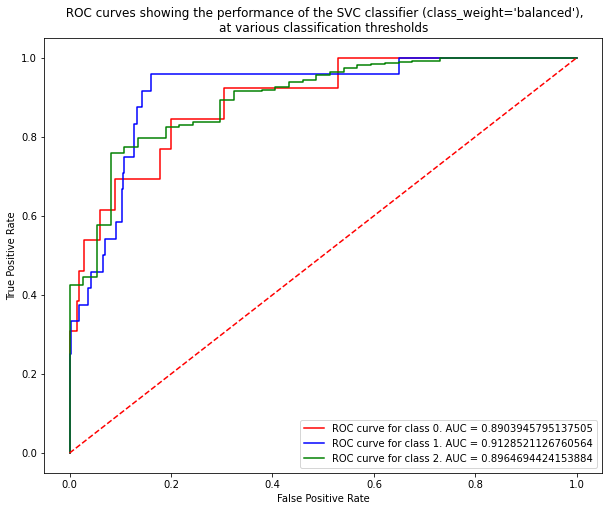

In [128]:
title = """ ROC curves showing the performance of the SVC classifier (class_weight='balanced'),
at various classification thresholds"""
plot_roc_curves(svctest_probs, title)

In [129]:
update_scores(svc, y_test, svctest_predictions, svctest_probs)

In [130]:
svc.test_metrics

{'rs': 0.518, 'ps': 0.901, 'fs': 0.6067, 'aucs': {0: 0.89, 1: 0.913, 2: 0.896}}

In [131]:
models_dict

{'mnb': MyMultinomialNB(name='mnb'),
 'oversampled_mnb': MyOversampledMultinomialNB(name='oversampled_mnb'),
 'rfc': MyRandomForestClassifier(name='rfc'),
 'xgb': MyXGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bynode=1, colsample_bytree=1,
                 enable_categorical=False, gamma=0, gpu_id=-1,
                 importance_type=None, interaction_constraints='',
                 learning_rate=0.300000012, max_delta_step=0, max_depth=6,
                 min_child_weight=1, missing=nan, monotone_constraints='()',
                 n_estimators=100, n_jobs=8, name='xgb', num_parallel_tree=1,
                 objective='multi:softprob', predictor='auto', random_state=100,
                 reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
                 tree_method='exact', use_label_encoder=False,
                 validate_parameters=1, ...),
 'oversampled_xgb': MyOversampledXGBClassifier(base_score=0.5, booster='gbtree'

In [132]:
generate_test_metrics_df()

,rs,ps,fs,auc_class0,auc_class1,auc_class2
mnb,0.333,0.312,0.3226,0.806,0.743,0.759
oversampled_mnb,0.700,0.502,0.5563,0.831,0.857,0.833
rfc,0.505,0.984,0.5969,0.880,0.811,0.814
xgb,0.546,0.838,0.6276,0.906,0.871,0.875
oversampled_xgb,0.511,0.614,0.5481,0.898,0.863,0.889
svc,0.518,0.901,0.6067,0.890,0.913,0.896


`The svc model does not do give as high an average f1 score as the xgb model. It must be noted, however, that the svc model has the hight auc for class 1. It suggest that it may be the best classifier for finding a classification threshold that can identify all the neutral reviews without misidentifying non - neutral reviews as being neutral.`

### Neural Networks

In [133]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential

In [134]:
y_train_binary = binarizer.transform(y_train)

In [135]:
print(X_train_matrix.shape, y_train_binary.shape, X_test_matrix.shape, y_test_binary.shape)

(3350, 3373) (3350, 3) (592, 3373) (592, 3)


In [136]:
class MyANN(Sequential):
    def __init__(self, name, test_metrics={}):
        super().__init__()
        self.name2 = name
        self.test_metrics = test_metrics
        models_dict.update({self.name2: self})

In [137]:
ann = MyANN('ann')

In [138]:
layers = [
    Dense(1000, input_dim=(X_train_matrix.shape[1]), activation='relu'),
    Dense(100, activation='relu'),
    Dense(25, activation='relu'),
    Dense(3, activation='softmax')
]

In [139]:
for layer in layers:
    ann.add(layer)

In [140]:
ann.summary()

Model: "my_ann"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              3374000   
_________________________________________________________________
dense_1 (Dense)              (None, 100)               100100    
_________________________________________________________________
dense_2 (Dense)              (None, 25)                2525      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 78        
Total params: 3,476,703
Trainable params: 3,476,703
Non-trainable params: 0
_________________________________________________________________


In [141]:
ann.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=['accuracy'])

In [142]:
ann_history = ann.fit(X_train_matrix.toarray(), y_train_binary, batch_size=64, epochs=30)

Epoch 1/30
53/53 [==============================] - 1s 13ms/step - loss: 0.4389 - accuracy: 0.9191
Epoch 2/30
53/53 [==============================] - 1s 13ms/step - loss: 0.1801 - accuracy: 0.9370
Epoch 3/30
53/53 [==============================] - 1s 13ms/step - loss: 0.1248 - accuracy: 0.9370
Epoch 4/30
53/53 [==============================] - 1s 13ms/step - loss: 0.0935 - accuracy: 0.9397
Epoch 5/30
53/53 [==============================] - 1s 14ms/step - loss: 0.0611 - accuracy: 0.9821
Epoch 6/30
53/53 [==============================] - 1s 13ms/step - loss: 0.0153 - accuracy: 0.9985
Epoch 7/30
53/53 [==============================] - 1s 14ms/step - loss: 0.0039 - accuracy: 0.9994
Epoch 8/30
53/53 [==============================] - 1s 13ms/step - loss: 9.0979e-04 - accuracy: 0.9997
Epoch 9/30
53/53 [==============================] - 1s 14ms/step - loss: 3.2195e-04 - accuracy: 1.0000
Epoch 10/30
53/53 [==============================] - 1s 14ms/step - loss: 2.1190e-04 - accuracy: 1.00

`With a minimum number of iterations of batch gradient descent, a fully conected neural network is able to learn a decision boundrary capable of separating the three classes in the training set.`

In [143]:
anntest_probs = ann.predict(X_test_matrix)
anntest_predictions= np.argmax(anntest_probs, axis=1)


In [144]:
anntest_probs

array([[2.2887380e-07, 2.3616597e-06, 9.9999738e-01],
       [2.0426616e-07, 4.5814713e-06, 9.9999523e-01],
       [1.3934605e-08, 4.4270931e-07, 9.9999952e-01],
       ...,
       [2.1604275e-14, 8.4184645e-13, 1.0000000e+00],
       [8.6387203e-10, 1.1028147e-08, 1.0000000e+00],
       [1.5393314e-01, 1.1680388e-02, 8.3438647e-01]], dtype=float32)

In [145]:
confusion_matrix(y_test, anntest_predictions)

array([[  4,   0,   9],
       [  1,   7,  16],
       [  4,   3, 548]], dtype=int64)

In [146]:
print_scores(y_test, anntest_predictions)

recall score: [0.30769231 0.29166667 0.98738739]
precision score: [0.44444444 0.7        0.95636998]
f1 score [0.36363636 0.41176471 0.97163121]
average f1 score: 0.5823440917308251


### The  ROC curves of the Artificial Neural Network 

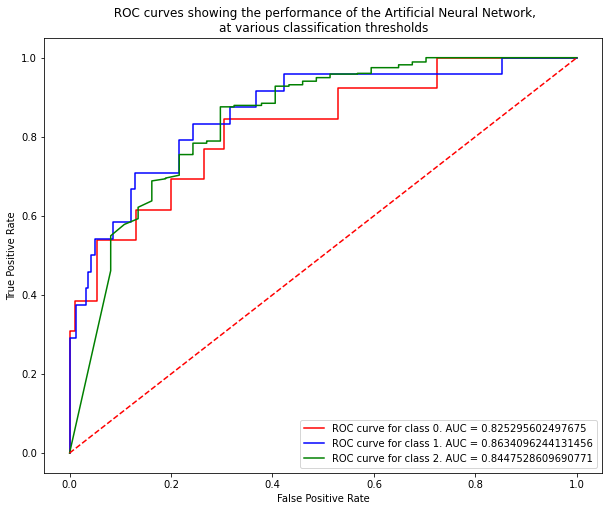

In [147]:
title = """ ROC curves showing the performance of the Artificial Neural Network,
at various classification thresholds"""
plot_roc_curves(anntest_probs, title)

In [148]:
 update_scores(ann, y_test, anntest_predictions, rfctest_probs)

In [149]:
ann.test_metrics

{'rs': 0.529, 'ps': 0.7, 'fs': 0.5823, 'aucs': {0: 0.88, 1: 0.811, 2: 0.814}}

In [150]:
models_dict

{'mnb': MyMultinomialNB(name='mnb'),
 'oversampled_mnb': MyOversampledMultinomialNB(name='oversampled_mnb'),
 'rfc': MyRandomForestClassifier(name='rfc'),
 'xgb': MyXGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bynode=1, colsample_bytree=1,
                 enable_categorical=False, gamma=0, gpu_id=-1,
                 importance_type=None, interaction_constraints='',
                 learning_rate=0.300000012, max_delta_step=0, max_depth=6,
                 min_child_weight=1, missing=nan, monotone_constraints='()',
                 n_estimators=100, n_jobs=8, name='xgb', num_parallel_tree=1,
                 objective='multi:softprob', predictor='auto', random_state=100,
                 reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
                 tree_method='exact', use_label_encoder=False,
                 validate_parameters=1, ...),
 'oversampled_xgb': MyOversampledXGBClassifier(base_score=0.5, booster='gbtree'

In [151]:
generate_test_metrics_df()

,rs,ps,fs,auc_class0,auc_class1,auc_class2
mnb,0.333,0.312,0.3226,0.806,0.743,0.759
oversampled_mnb,0.700,0.502,0.5563,0.831,0.857,0.833
rfc,0.505,0.984,0.5969,0.880,0.811,0.814
xgb,0.546,0.838,0.6276,0.906,0.871,0.875
oversampled_xgb,0.511,0.614,0.5481,0.898,0.863,0.889
svc,0.518,0.901,0.6067,0.890,0.913,0.896
ann,0.529,0.700,0.5823,0.880,0.811,0.814


`The ann does not outperform the other models in any area.`

### Neural Network with class weight balanced

In [152]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2]), array([  77,  134, 3139], dtype=int64))

In [153]:
num_0, num_1, num_2 = np.unique(y_train, return_counts=True)[1]
total = num_0 + num_1 + num_2
print(total)

3350


In [154]:
weight_0 = (1/num_0) * (total/3)
weight_1 = (1/num_1) * (total/3)
weight_2 = (1/num_2) * (total/3)
class_weight = {0: weight_0, 1: weight_1, 2: weight_2}
class_weight

{0: 14.502164502164504, 1: 8.333333333333334, 2: 0.355739619836466}

In [155]:
layers = [
    Dense(1000, input_dim=(X_train_matrix.shape[1]), activation='relu'),
    Dense(100, activation='relu'),
    Dense(25, activation='relu'),
    Dense(3, activation='softmax')
]

In [156]:
class MyBalancedANN(Sequential):
    def __init__(self, name, test_metrics={}):
        super().__init__()
        self.name2 = name
        self.test_metrics = test_metrics
        models_dict.update({self.name2: self})

In [157]:
balanced_ann = MyBalancedANN('balanced_ann')

In [158]:
for layer in layers:
    balanced_ann.add(layer)

In [159]:
balanced_ann.summary()

Model: "my_balanced_ann"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1000)              3374000   
_________________________________________________________________
dense_5 (Dense)              (None, 100)               100100    
_________________________________________________________________
dense_6 (Dense)              (None, 25)                2525      
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 78        
Total params: 3,476,703
Trainable params: 3,476,703
Non-trainable params: 0
_________________________________________________________________


In [160]:
balanced_ann.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=['accuracy'])

In [161]:
balanced_ann_history = balanced_ann.fit(X_train_matrix.toarray(), y_train_binary, batch_size=64, epochs=60, class_weight=class_weight)

Epoch 1/60
53/53 [==============================] - 1s 14ms/step - loss: 1.0665 - accuracy: 0.8809
Epoch 2/60
53/53 [==============================] - 1s 14ms/step - loss: 0.6080 - accuracy: 0.8907
Epoch 3/60
53/53 [==============================] - 1s 13ms/step - loss: 0.1788 - accuracy: 0.9445
Epoch 4/60
53/53 [==============================] - 1s 14ms/step - loss: 0.0426 - accuracy: 0.9794
Epoch 5/60
53/53 [==============================] - 1s 14ms/step - loss: 0.0123 - accuracy: 0.9943
Epoch 6/60
53/53 [==============================] - 1s 14ms/step - loss: 0.0067 - accuracy: 0.9982
Epoch 7/60
53/53 [==============================] - 1s 13ms/step - loss: 0.0039 - accuracy: 0.9991
Epoch 8/60
53/53 [==============================] - 1s 13ms/step - loss: 0.0027 - accuracy: 0.9994
Epoch 9/60
53/53 [==============================] - 1s 15ms/step - loss: 0.0018 - accuracy: 0.9994
Epoch 10/60
53/53 [==============================] - 1s 14ms/step - loss: 0.0012 - accuracy: 0.9997
Epoch 11/

In [162]:
balanced_anntest_probs = balanced_ann.predict(X_test_matrix)
balanced_anntest_predictions= np.argmax(balanced_anntest_probs, axis=1)


In [163]:
balanced_anntest_probs

array([[3.1338345e-07, 3.0442897e-07, 9.9999940e-01],
       [3.9921087e-08, 1.3701102e-06, 9.9999857e-01],
       [2.0812774e-09, 6.9804472e-08, 9.9999988e-01],
       ...,
       [9.0833213e-15, 1.0893653e-13, 1.0000000e+00],
       [4.2267670e-10, 1.3114941e-09, 1.0000000e+00],
       [9.7995561e-01, 1.4099422e-03, 1.8634502e-02]], dtype=float32)

In [164]:
confusion_matrix(y_test, balanced_anntest_predictions)

array([[  5,   0,   8],
       [  1,   8,  15],
       [  7,   8, 540]], dtype=int64)

In [165]:
print_scores(y_test, balanced_anntest_predictions)

recall score: [0.38461538 0.33333333 0.97297297]
precision score: [0.38461538 0.5        0.95914742]
f1 score [0.38461538 0.4        0.96601073]
average f1 score: 0.5835420393559928


### The  ROC curves of the Artificial Neural Network  with class weights balanced

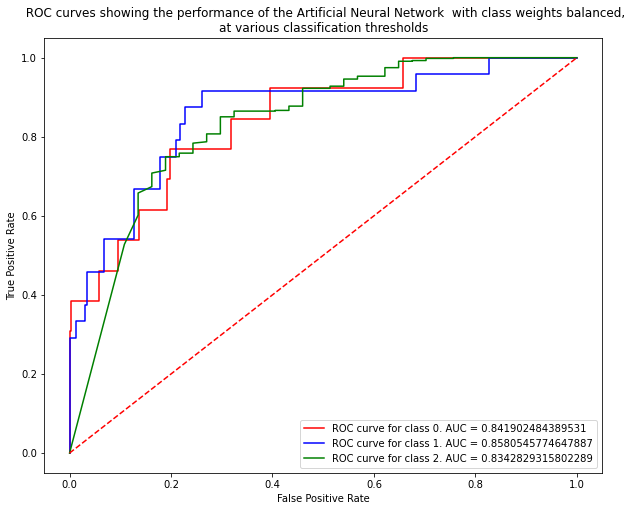

In [166]:
title = """ ROC curves showing the performance of the Artificial Neural Network  with class weights balanced,
at various classification thresholds"""
plot_roc_curves(balanced_anntest_probs, title)

In [167]:
update_scores(balanced_ann, y_test, balanced_anntest_predictions, balanced_anntest_probs)

In [168]:
balanced_ann.test_metrics

{'rs': 0.564,
 'ps': 0.615,
 'fs': 0.5835,
 'aucs': {0: 0.842, 1: 0.858, 2: 0.834}}

In [169]:
models_dict

{'mnb': MyMultinomialNB(name='mnb'),
 'oversampled_mnb': MyOversampledMultinomialNB(name='oversampled_mnb'),
 'rfc': MyRandomForestClassifier(name='rfc'),
 'xgb': MyXGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bynode=1, colsample_bytree=1,
                 enable_categorical=False, gamma=0, gpu_id=-1,
                 importance_type=None, interaction_constraints='',
                 learning_rate=0.300000012, max_delta_step=0, max_depth=6,
                 min_child_weight=1, missing=nan, monotone_constraints='()',
                 n_estimators=100, n_jobs=8, name='xgb', num_parallel_tree=1,
                 objective='multi:softprob', predictor='auto', random_state=100,
                 reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
                 tree_method='exact', use_label_encoder=False,
                 validate_parameters=1, ...),
 'oversampled_xgb': MyOversampledXGBClassifier(base_score=0.5, booster='gbtree'

In [170]:
generate_test_metrics_df()

,rs,ps,fs,auc_class0,auc_class1,auc_class2
mnb,0.333,0.312,0.3226,0.806,0.743,0.759
oversampled_mnb,0.700,0.502,0.5563,0.831,0.857,0.833
rfc,0.505,0.984,0.5969,0.880,0.811,0.814
xgb,0.546,0.838,0.6276,0.906,0.871,0.875
oversampled_xgb,0.511,0.614,0.5481,0.898,0.863,0.889
svc,0.518,0.901,0.6067,0.890,0.913,0.896
ann,0.529,0.700,0.5823,0.880,0.811,0.814
balanced_ann,0.564,0.615,0.5835,0.842,0.858,0.834


`The ANN trained with balanced class weigths does not improve overall performance. It does do better job of recalling the minority classes but does so at the expense of increased false positivity rates.`

### ANN on imbalanced data vs ANN with class weights balanced

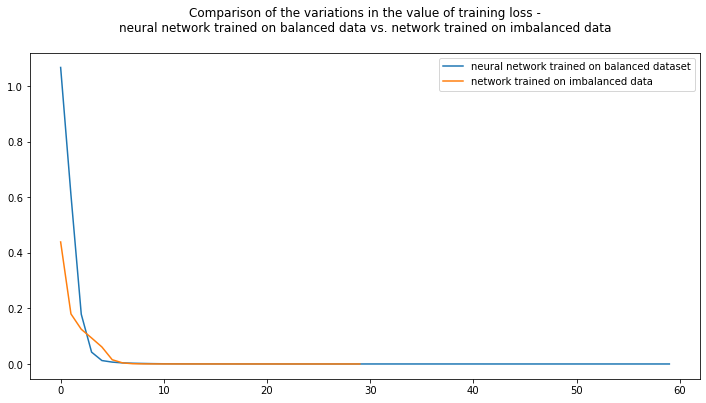

In [171]:
plt.figure(figsize=(12, 6))
plt.plot(balanced_ann_history.history['loss'], label="neural network trained on balanced dataset")
plt.plot(ann_history.history['loss'], label="network trained on imbalanced data")
plt.title("""Comparison of the variations in the value of training loss -
neural network trained on balanced data vs. network trained on imbalanced data
""")
plt.legend(loc=1)
plt.show()

`From the graph above we clearly see that balancing classweights causes slightly faster convergence of the loss function but does not improve performance of the network.`

### Ensemble Techniques

In [172]:
from sklearn.ensemble import VotingClassifier

In [173]:
clf1 = XGBClassifier(random_state=100, use_label_encoder=False)


In [174]:
clf2 = MultinomialNB()

In [175]:
estimators = [('xgb', clf1), ('mnb', clf2)]

In [176]:
class MyVotingClassifier(VotingClassifier):
    def __init__(self, name, test_metrics={}):
        super().__init__(estimators = [('xgb', clf1), ('mnb', clf2)], voting="soft")
        self.name = name
        self.test_metrics = test_metrics
        models_dict.update({self.name: self})


In [177]:
vot = MyVotingClassifier('vot')

In [178]:
vot.fit(X_res, y_res)

[07:26:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


MyVotingClassifier(name='vot')

In [179]:
vottrain_predicitons = vot.predict(X_train_matrix)
vottest_predictions = vot.predict(X_test_matrix)
vottest_probs = vot.predict_proba(X_test_matrix)

In [180]:
confusion_matrix(y_train, vottrain_predicitons)

array([[  77,    0,    0],
       [   0,  128,    6],
       [   1,    4, 3134]], dtype=int64)

In [181]:
print_scores(y_train, vottrain_predicitons)

recall score: [1.         0.95522388 0.99840714]
precision score: [0.98717949 0.96969697 0.99808917]
f1 score [0.99354839 0.96240602 0.99824813]
average f1 score: 0.9847341769390932


In [182]:
confusion_matrix(y_test, vottest_predictions)

array([[  4,   0,   9],
       [  1,   8,  15],
       [  1,   8, 546]], dtype=int64)

In [183]:
print_scores(y_test, vottest_predictions)


recall score: [0.30769231 0.33333333 0.98378378]
precision score: [0.66666667 0.5        0.95789474]
f1 score [0.42105263 0.4        0.97066667]
average f1 score: 0.5972397660818713


### The  ROC curves of the Voting Classifier

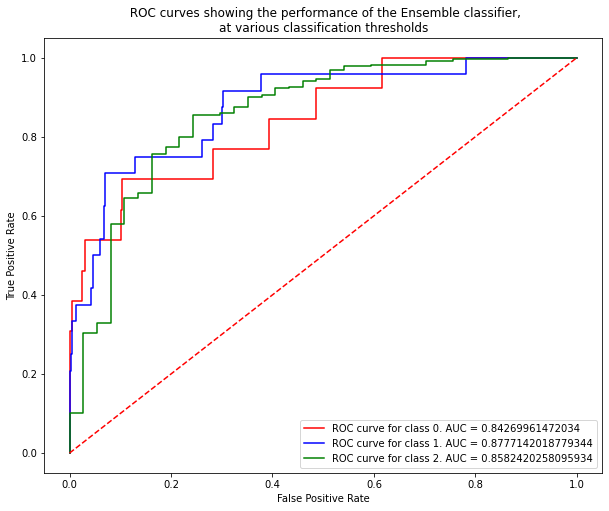

In [184]:
title = """ ROC curves showing the performance of the Ensemble classifier,
at various classification thresholds"""
plot_roc_curves(vottest_probs, title)

In [185]:
update_scores(vot,  y_test, vottest_predictions, vottest_probs)

In [186]:
vot.test_metrics

{'rs': 0.542,
 'ps': 0.708,
 'fs': 0.5972,
 'aucs': {0: 0.843, 1: 0.878, 2: 0.858}}

In [187]:
models_dict

{'mnb': MyMultinomialNB(name='mnb'),
 'oversampled_mnb': MyOversampledMultinomialNB(name='oversampled_mnb'),
 'rfc': MyRandomForestClassifier(name='rfc'),
 'xgb': MyXGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bynode=1, colsample_bytree=1,
                 enable_categorical=False, gamma=0, gpu_id=-1,
                 importance_type=None, interaction_constraints='',
                 learning_rate=0.300000012, max_delta_step=0, max_depth=6,
                 min_child_weight=1, missing=nan, monotone_constraints='()',
                 n_estimators=100, n_jobs=8, name='xgb', num_parallel_tree=1,
                 objective='multi:softprob', predictor='auto', random_state=100,
                 reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
                 tree_method='exact', use_label_encoder=False,
                 validate_parameters=1, ...),
 'oversampled_xgb': MyOversampledXGBClassifier(base_score=0.5, booster='gbtree'

In [188]:
generate_test_metrics_df()

,rs,ps,fs,auc_class0,auc_class1,auc_class2
mnb,0.333,0.312,0.3226,0.806,0.743,0.759
oversampled_mnb,0.700,0.502,0.5563,0.831,0.857,0.833
rfc,0.505,0.984,0.5969,0.880,0.811,0.814
xgb,0.546,0.838,0.6276,0.906,0.871,0.875
oversampled_xgb,0.511,0.614,0.5481,0.898,0.863,0.889
svc,0.518,0.901,0.6067,0.890,0.913,0.896
ann,0.529,0.700,0.5823,0.880,0.811,0.814
balanced_ann,0.564,0.615,0.5835,0.842,0.858,0.834
vot,0.542,0.708,0.5972,0.843,0.878,0.858


`This particular ensemble method does not give us better results than any of the classifiers that we have built so far.`

### Classification using an engineered sentiment score feature

For this project VADER (Valence Aware Dictionary and Sentiment Reasoner), a lexicon and rule based sentiment analysis tool will be used to generate sentiment scores for each review.

In [189]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [190]:
analyzer = SentimentIntensityAnalyzer()

def sentiment_score_calculator(review):
    """
    This function takes a document / piece of text and returns a sentiment score based
    on the Valence Aware Dictionary and Sentiment Reasoner, a lexicon and rule based sentiment analysis tool.
    """
    scores = analyzer.polarity_scores(review)
    score1 = scores['compound']
    
    return score1

In [191]:
cleaned_reviews.head()

0    purchase black fridaypro great price even sale...
1    purchase two amazon echo plus two dot plus fou...
2    average alexa option show thing screen still l...
3                 good product exactly want good price
4    one purchase buy one niece case compare one ho...
Name: reviews.text, dtype: object

In [192]:
sentiment_score_calculator(cleaned_reviews.iloc[0])

0.9682

In [193]:
sentiment_score = cleaned_reviews.apply(sentiment_score_calculator)
sentiment_score.name = 'sentiment_score'
sentiment_score.head()

0    0.9682
1    0.9287
2    0.0000
3    0.7269
4    0.1280
Name: sentiment_score, dtype: float64

In [194]:
train_df2 = pd.concat([train_df, sentiment_score], axis=1)
train_df2.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment,sentiment_score
0,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-26T00:00:00.000Z,Purchased on Black FridayPros - Great Price (e...,Powerful tablet,Positive,0.9682
1,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-17T00:00:00.000Z,I purchased two Amazon in Echo Plus and two do...,Amazon Echo Plus AWESOME,Positive,0.9287
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-20T00:00:00.000Z,Just an average Alexa option. Does show a few ...,Average,Neutral,0.0000
3,"Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 ...",Amazon,"eBook Readers,Fire Tablets,Electronics Feature...","Office Supplies,Electronics",2017-08-04T00:00:00.000Z,"very good product. Exactly what I wanted, and ...",Greattttttt,Positive,0.7269
4,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-01-23T00:00:00.000Z,This is the 3rd one I've purchased. I've bough...,Very durable!,Positive,0.1280


In [195]:
X_train.head()


3081    think download new app wait surf web thing slo...
1775    purchase yr old love fact play game movie love...
3510    buy son size perfect small big kid friendly ea...
337       big good kindle yet light feather buy one today
3327                   granddaughter love use school work
Name: reviews.text, dtype: object

In [196]:
sent_scores_for_x_train = train_df2.loc[X_train.index].sentiment_score
sent_scores_for_x_test = train_df2.loc[X_test.index].sentiment_score
#The code above will filter the values in the sentiment_score column by the index.
#It will match the documents in X_train to their correct sentiment values, and by extension
    #the values in X_train_matrix to their correct sentiment.

In [197]:
print(X_train.head(), sent_scores_for_x_train.head(), sep='\n')
#The matching index numbers for X_train and sent_scores_for_x_train indicate our data aligns perfectly, as expected.
#Since the order of X_train_matrix and X_train are the same, we can therefore 
    #horizontally concatenate X_train_matrix and sent_scores_for_x_train; 
    #This will to add sentiment score as a feature to our model.

3081    think download new app wait surf web thing slo...
1775    purchase yr old love fact play game movie love...
3510    buy son size perfect small big kid friendly ea...
337       big good kindle yet light feather buy one today
3327                   granddaughter love use school work
Name: reviews.text, dtype: object
3081    0.6249
1775    0.8957
3510    0.7964
337     0.4404
3327    0.6369
Name: sentiment_score, dtype: float64


In [198]:
print(X_test.head(), sent_scores_for_x_test.head(), sep='\n')

2268            good electronic purchase year great price
3156                     solid product great kid like lot
1683    amazon prime year new fire hd make worth watch...
1408    look cost effective solution satisfy children ...
3749            great easy download book screen easy read
Name: reviews.text, dtype: object
2268    0.7906
3156    0.8020
1683    0.0516
1408    0.9442
3749    0.8720
Name: sentiment_score, dtype: float64


In [199]:
print(X_train_matrix.shape, sent_scores_for_x_train.shape, X_test_matrix.shape, sent_scores_for_x_test.shape)

(3350, 3373) (3350,) (592, 3373) (592,)


In [200]:
X_train_matrix_with_sent_score = np.hstack([X_train_matrix.toarray(), sent_scores_for_x_train.values.reshape(-1, 1)])
X_test_matrix_with_sent_score = np.hstack([X_test_matrix.toarray(), sent_scores_for_x_test.values.reshape(-1, 1)])

In [201]:
print( X_train_matrix.shape, X_test_matrix.shape, X_train_matrix_with_sent_score.shape, 
      X_test_matrix_with_sent_score.shape,)
#As we can see, both the train and test matrices now have an additional feature.
#This feature is the sentiment score.

(3350, 3373) (592, 3373) (3350, 3374) (592, 3374)


In [202]:
X_train_matrix_with_sent_score[:, -5:]
#Below we can confirm that the right most column of the X_train_matrix array, contains the sentiment scores.

array([[0.    , 0.    , 0.    , 0.    , 0.6249],
       [0.    , 0.    , 0.    , 0.    , 0.8957],
       [0.    , 0.    , 0.    , 0.    , 0.7964],
       ...,
       [0.    , 0.    , 0.    , 0.    , 0.6908],
       [0.    , 0.    , 0.    , 0.    , 0.7964],
       [0.    , 0.    , 0.    , 0.    , 0.6369]])

### Model Training using Sentiment Score

To train the model using sentiment score, we will be using the model that has so far yielded the best f1 scores, the xgb model.


In [203]:
class MySentimentXGBClassifier(XGBClassifier):   
    def __init__(self, name, test_metrics={}):
        super().__init__(use_label_encoder=False ,random_state=100)
        self.name = name
        self.test_metrics = test_metrics
        models_dict.update({self.name: self})

In [204]:
sentscore_xgb = MySentimentXGBClassifier('sentscore_xgb')

In [205]:
sentscore_xgb.fit(X_train_matrix_with_sent_score, y_train)

[07:27:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "name", "test_metrics" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:27:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


MySentimentXGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                         colsample_bynode=1, colsample_bytree=1,
                         enable_categorical=False, gamma=0, gpu_id=-1,
                         importance_type=None, interaction_constraints='',
                         learning_rate=0.300000012, max_delta_step=0,
                         max_depth=6, min_child_weight=1, missing=nan,
                         monotone_constraints='()', n_estimators=100, n_jobs=8,
                         name='sentscore_xgb', num_parallel_tree=1,
                         objective='multi:softprob', predictor='auto',
                         random_state=100, reg_alpha=0, reg_lambda=1,
                         scale_pos_weight=None, subsample=1,
                         tree_method='exact', use_label_encoder=False,
                         validate_parameters=1, ...)

In [206]:
sentscore_xgbtraain_predictions = sentscore_xgb.predict(X_train_matrix_with_sent_score)
sentscore_xgbtest_predictions = sentscore_xgb.predict(X_test_matrix_with_sent_score)
sentscore_xgbtest_probs = sentscore_xgb.predict_proba(X_test_matrix_with_sent_score)


In [207]:
confusion_matrix(y_train, sentscore_xgbtraain_predictions)

array([[  77,    0,    0],
       [   0,  119,   15],
       [   0,    0, 3139]], dtype=int64)

In [208]:
confusion_matrix(y_test, sentscore_xgbtest_predictions)

array([[  4,   1,   8],
       [  1,   8,  15],
       [  1,   5, 549]], dtype=int64)

In [209]:
print_scores(y_test, sentscore_xgbtest_predictions)
#The sentiment score computed using vader does not improve model performance.

recall score: [0.30769231 0.33333333 0.98918919]
precision score: [0.66666667 0.57142857 0.95979021]
f1 score [0.42105263 0.42105263 0.97426797]
average f1 score: 0.6054577437382275


### The  ROC curves of the XGB classifier trained with an sentiment score feature.

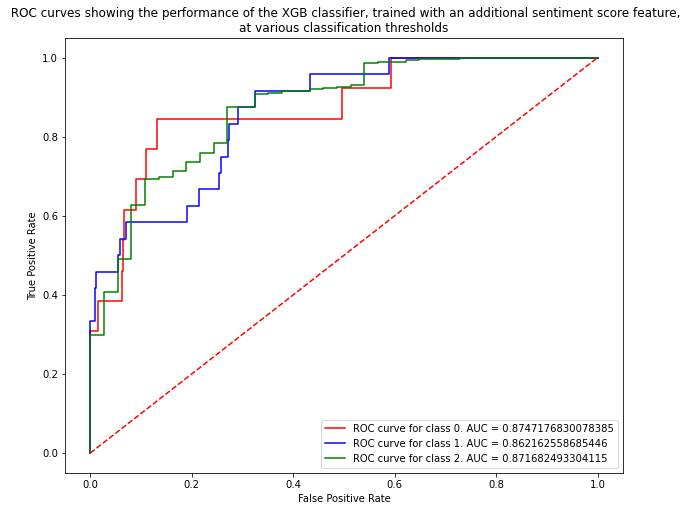

In [210]:
title = """ ROC curves showing the performance of the XGB classifier, trained with an additional sentiment score feature,
at various classification thresholds"""
plot_roc_curves(sentscore_xgbtest_probs, title)

In [211]:
 update_scores(sentscore_xgb, y_test, sentscore_xgbtest_predictions, sentscore_xgbtest_probs)

In [212]:
sentscore_xgb.test_metrics

{'rs': 0.543,
 'ps': 0.733,
 'fs': 0.6055,
 'aucs': {0: 0.875, 1: 0.862, 2: 0.872}}

In [213]:
models_dict

{'mnb': MyMultinomialNB(name='mnb'),
 'oversampled_mnb': MyOversampledMultinomialNB(name='oversampled_mnb'),
 'rfc': MyRandomForestClassifier(name='rfc'),
 'xgb': MyXGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bynode=1, colsample_bytree=1,
                 enable_categorical=False, gamma=0, gpu_id=-1,
                 importance_type=None, interaction_constraints='',
                 learning_rate=0.300000012, max_delta_step=0, max_depth=6,
                 min_child_weight=1, missing=nan, monotone_constraints='()',
                 n_estimators=100, n_jobs=8, name='xgb', num_parallel_tree=1,
                 objective='multi:softprob', predictor='auto', random_state=100,
                 reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
                 tree_method='exact', use_label_encoder=False,
                 validate_parameters=1, ...),
 'oversampled_xgb': MyOversampledXGBClassifier(base_score=0.5, booster='gbtree'

In [214]:
generate_test_metrics_df()

,rs,ps,fs,auc_class0,auc_class1,auc_class2
mnb,0.333,0.312,0.3226,0.806,0.743,0.759
oversampled_mnb,0.700,0.502,0.5563,0.831,0.857,0.833
rfc,0.505,0.984,0.5969,0.880,0.811,0.814
xgb,0.546,0.838,0.6276,0.906,0.871,0.875
oversampled_xgb,0.511,0.614,0.5481,0.898,0.863,0.889
svc,0.518,0.901,0.6067,0.890,0.913,0.896
ann,0.529,0.700,0.5823,0.880,0.811,0.814
balanced_ann,0.564,0.615,0.5835,0.842,0.858,0.834
vot,0.542,0.708,0.5972,0.843,0.878,0.858
sentscore_xgb,0.543,0.733,0.6055,0.875,0.862,0.872


`The sentiment score calculated using VADER does not seem to improve the performance of the XGB algorithm.`

### LSTM

In [215]:
from tensorflow.keras.layers import LSTM, Flatten, Dense, Input, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [216]:
X_train

3081    think download new app wait surf web thing slo...
1775    purchase yr old love fact play game movie love...
3510    buy son size perfect small big kid friendly ea...
337       big good kindle yet light feather buy one today
3327                   granddaughter love use school work
                              ...                        
1247    sure join amazon prime access lot free reading...
1612            love fact use voice use electronic device
3210    life saver recent cross country flight nice wo...
413                   echo love product purchase tap gift
1821                         love listen music turn light
Name: reviews.text, Length: 3350, dtype: object

In [217]:
vocab_size=3000
tokenizer = Tokenizer(num_words=vocab_size)


In [218]:
tokenizer.fit_on_texts(X_train )

In [219]:
len(tokenizer.word_index)
#We will not include the 387 least commonly occuring words in the vocabulary

3387

In [220]:
X_train_tokenized = tokenizer.texts_to_sequences(X_train)
X_test_tokenized = tokenizer.texts_to_sequences(X_test)

In [221]:
print(X_train_tokenized[:2])
#x_train_tokenized is a list of lists
#Each list is a sequence of integers, each representing a word

[[106, 82, 50, 25, 292, 480, 240, 47, 260, 460, 23, 2002, 86, 12, 37, 5, 545, 876, 316, 1517, 35, 48, 21, 109, 1253, 129, 83, 546, 9, 261, 45, 425, 481, 5, 3, 3, 341, 460, 523], [17, 342, 23, 1, 343, 20, 36, 103, 1, 211, 74, 58, 597, 38]]


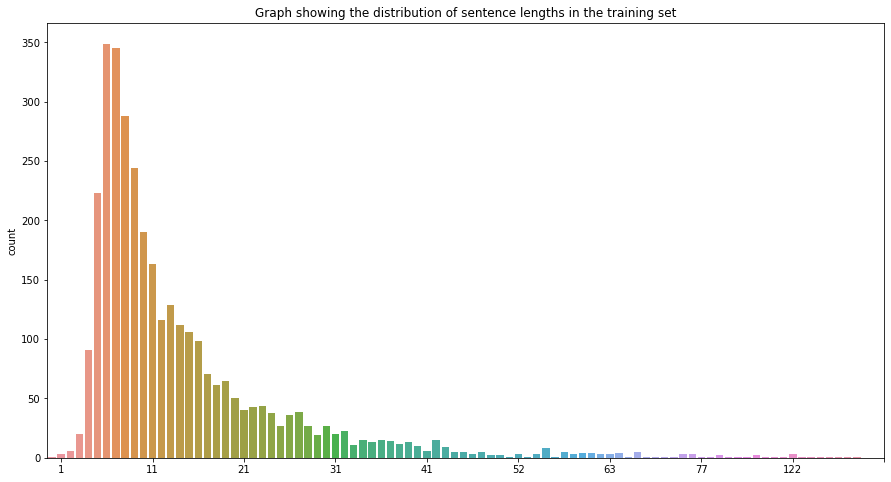

In [222]:
plt.figure(figsize=(15, 8))
sns.countplot(x=[len(seq) for seq in X_train_tokenized])
plt.xticks(np.arange(1, 100, 10))
plt.title("Graph showing the distribution of sentence lengths in the training set")
plt.show()

In [223]:
X_train_for_lstm = pad_sequences(X_train_tokenized, maxlen=50, truncating='post')
X_test_for_lstm = pad_sequences(X_test_tokenized, maxlen=50, truncating='post')

In [224]:
print(X_train_for_lstm.shape, X_test_for_lstm.shape)

(3350, 50) (592, 50)


In [225]:
lstm_layers = [Embedding(input_dim=vocab_size, output_dim=300, input_length=50),
     LSTM(100, return_sequences=True),
     LSTM(20),
     Dense(10, activation='softmax'),
     Dense(3, activation='softmax'),
        
    ]

In [226]:
class MyLSTM(Sequential):
    def __init__(self, name, test_metrics={}):
        super().__init__()
        self.name2 = name
        self.test_metrics = test_metrics
        models_dict.update({self.name2: self})

In [227]:
lstm = MyLSTM('lstm')

In [228]:
for layer in lstm_layers:
    lstm.add(layer)

In [229]:
lstm.summary()

Model: "my_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 300)           900000    
_________________________________________________________________
lstm (LSTM)                  (None, 50, 100)           160400    
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                9680      
_________________________________________________________________
dense_8 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 33        
Total params: 1,070,323
Trainable params: 1,070,323
Non-trainable params: 0
_________________________________________________________________


In [230]:
lstm.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

In [231]:
lstm_history = lstm.fit(X_train_for_lstm, y_train, batch_size=64, epochs=60, verbose=1)

Epoch 1/60
53/53 [==============================] - 6s 67ms/step - loss: 0.7673 - accuracy: 0.9370
Epoch 2/60
53/53 [==============================] - 4s 67ms/step - loss: 0.5805 - accuracy: 0.9370
Epoch 3/60
53/53 [==============================] - 4s 68ms/step - loss: 0.5146 - accuracy: 0.9370
Epoch 4/60
53/53 [==============================] - 4s 67ms/step - loss: 0.4658 - accuracy: 0.9370
Epoch 5/60
53/53 [==============================] - 4s 68ms/step - loss: 0.4279 - accuracy: 0.9370
Epoch 6/60
53/53 [==============================] - 4s 67ms/step - loss: 0.3982 - accuracy: 0.9370
Epoch 7/60
53/53 [==============================] - 4s 68ms/step - loss: 0.3747 - accuracy: 0.9370
Epoch 8/60
53/53 [==============================] - 3s 66ms/step - loss: 0.3560 - accuracy: 0.9370
Epoch 9/60
53/53 [==============================] - 4s 67ms/step - loss: 0.3410 - accuracy: 0.9370
Epoch 10/60
53/53 [==============================] - 4s 66ms/step - loss: 0.3290 - accuracy: 0.9370
Epoch 11/

In [232]:
lstmtrain_probs = lstm.predict(X_train_for_lstm)
lstmtrain_predictions= np.argmax(lstmtrain_probs, axis=1)
lstmtest_probs = lstm.predict(X_test_for_lstm)
lstmtest_predictions= np.argmax(lstmtest_probs, axis=1)



In [233]:
confusion_matrix(y_train, lstmtrain_predictions)
#The LSTM simply classifies all examples as belonging to class 2

array([[   0,    0,   77],
       [   0,    0,  134],
       [   0,    0, 3139]], dtype=int64)

In [234]:
confusion_matrix(y_test, lstmtest_predictions)

array([[  0,   0,  13],
       [  0,   0,  24],
       [  0,   0, 555]], dtype=int64)

In [235]:
print_scores(y_test, lstmtest_predictions)

recall score: [0. 0. 1.]
precision score: [0.     0.     0.9375]
f1 score [0.         0.         0.96774194]
average f1 score: 0.3225806451612903


In [236]:
update_scores(lstm, y_test, lstmtest_predictions, lstmtest_probs)

In [237]:
lstm.test_metrics

{'rs': 0.333,
 'ps': 0.312,
 'fs': 0.3226,
 'aucs': {0: 0.747, 1: 0.662, 2: 0.557}}

In [238]:
generate_test_metrics_df()

,rs,ps,fs,auc_class0,auc_class1,auc_class2
mnb,0.333,0.312,0.3226,0.806,0.743,0.759
oversampled_mnb,0.700,0.502,0.5563,0.831,0.857,0.833
rfc,0.505,0.984,0.5969,0.880,0.811,0.814
xgb,0.546,0.838,0.6276,0.906,0.871,0.875
oversampled_xgb,0.511,0.614,0.5481,0.898,0.863,0.889
svc,0.518,0.901,0.6067,0.890,0.913,0.896
ann,0.529,0.700,0.5823,0.880,0.811,0.814
balanced_ann,0.564,0.615,0.5835,0.842,0.858,0.834
vot,0.542,0.708,0.5972,0.843,0.878,0.858
sentscore_xgb,0.543,0.733,0.6055,0.875,0.862,0.872


`The LSTM network does a very poor job at finding a decision boundrary between the classes.`



### LSTM with balanced data

In [239]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall

In [240]:
class MyBalancedLSTM(Sequential):
    def __init__(self, name, test_metrics={}):
        super().__init__()
        self.name2 = name
        self.test_metrics = test_metrics
        models_dict.update({self.name2: self})

In [241]:
balanced_lstm = MyBalancedLSTM('balanced_lstm')

In [242]:
lstm_layers = [Embedding(input_dim=vocab_size, output_dim=300, input_length=50),
     LSTM(100, return_sequences=True),
     LSTM(20),
     Dense(10, activation='softmax'),
     Dense(3, activation='softmax'),
        
    ]

In [243]:
for layer in lstm_layers:
    balanced_lstm.add(layer)

In [244]:
balanced_lstm.summary()

Model: "my_balanced_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           900000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 100)           160400    
_________________________________________________________________
lstm_3 (LSTM)                (None, 20)                9680      
_________________________________________________________________
dense_10 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 33        
Total params: 1,070,323
Trainable params: 1,070,323
Non-trainable params: 0
_________________________________________________________________


In [245]:
recall = Recall(name='recall', class_id=0)
#We will choose the model parmaters that best recall the instances of the minority class (class 0)

In [246]:
balanced_lstm.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=['accuracy', recall])

In [247]:
class_weight

{0: 14.502164502164504, 1: 8.333333333333334, 2: 0.355739619836466}

In [248]:
callbacks = EarlyStopping(monitor='recall', mode='max', patience=30, restore_best_weights=True)

In [249]:
balanced_lstm_history = balanced_lstm.fit(X_train_for_lstm, 
                                          y_train_binary, batch_size=64, epochs=100, verbose=1, 
                                          class_weight=class_weight, callbacks=callbacks)

Epoch 1/100
53/53 [==============================] - 5s 61ms/step - loss: 1.0954 - accuracy: 0.9307 - recall: 0.0000e+00
Epoch 2/100
53/53 [==============================] - 3s 61ms/step - loss: 0.9975 - accuracy: 0.8848 - recall: 0.1299 ETA: 1s - loss: 1.0668 - accuracy
Epoch 3/100
53/53 [==============================] - 3s 61ms/step - loss: 0.8486 - accuracy: 0.8507 - recall: 0.7143
Epoch 4/100
53/53 [==============================] - 3s 64ms/step - loss: 0.7191 - accuracy: 0.9212 - recall: 0.8442
Epoch 5/100
53/53 [==============================] - 3s 65ms/step - loss: 0.6164 - accuracy: 0.9212 - recall: 0.9481: 2s - loss: 0.6552 - 
Epoch 6/100
53/53 [==============================] - 3s 65ms/step - loss: 0.5520 - accuracy: 0.9451 - recall: 0.9481
Epoch 7/100
53/53 [==============================] - 3s 63ms/step - loss: 0.5319 - accuracy: 0.9525 - recall: 0.9091
Epoch 8/100
53/53 [==============================] - 3s 64ms/step - loss: 0.4629 - accuracy: 0.9493 - recall: 0.9740: 0s 

In [250]:
balanced_lstmtrain_probs = balanced_lstm.predict(X_train_for_lstm)
balanced_lstmtrain_predictions= np.argmax(balanced_lstmtrain_probs, axis=1)
balanced_lstmtest_probs = balanced_lstm.predict(X_test_for_lstm)
balanced_lstmtest_predictions= np.argmax(balanced_lstmtest_probs, axis=1)



In [251]:
confusion_matrix(y_train, balanced_lstmtrain_predictions)


array([[  75,    0,    2],
       [   2,  131,    1],
       [  12,   70, 3057]], dtype=int64)

In [252]:
confusion_matrix(y_test, balanced_lstmtest_predictions)

array([[  6,   2,   5],
       [  0,  14,  10],
       [  3,  27, 525]], dtype=int64)

In [253]:
print_scores(y_test, balanced_lstmtest_predictions)

recall score: [0.46153846 0.58333333 0.94594595]
precision score: [0.66666667 0.3255814  0.97222222]
f1 score [0.54545455 0.41791045 0.95890411]
average f1 score: 0.6407563676015936


In [254]:
update_scores(balanced_lstm, y_test, balanced_lstmtest_predictions, balanced_lstmtest_probs)

In [255]:
balanced_lstm.test_metrics

{'rs': 0.664,
 'ps': 0.655,
 'fs': 0.6408,
 'aucs': {0: 0.779, 1: 0.875, 2: 0.882}}

In [256]:
generate_test_metrics_df()

,rs,ps,fs,auc_class0,auc_class1,auc_class2
mnb,0.333,0.312,0.3226,0.806,0.743,0.759
oversampled_mnb,0.700,0.502,0.5563,0.831,0.857,0.833
rfc,0.505,0.984,0.5969,0.880,0.811,0.814
xgb,0.546,0.838,0.6276,0.906,0.871,0.875
oversampled_xgb,0.511,0.614,0.5481,0.898,0.863,0.889
svc,0.518,0.901,0.6067,0.890,0.913,0.896
ann,0.529,0.700,0.5823,0.880,0.811,0.814
balanced_ann,0.564,0.615,0.5835,0.842,0.858,0.834
vot,0.542,0.708,0.5972,0.843,0.878,0.858
sentscore_xgb,0.543,0.733,0.6055,0.875,0.862,0.872


### Discussion


Despite the LSTM trained with balanced classes giving the highest F1 score of all the models, keen analysis of the auc scor each of the models show that there are other models that are more promising for this particular task.

It must be stated that LSTM's are quite suited for this particular task, and prior to the analysis, may have been expected to outperform other models. The relatively underwhleming performance of the LSTM network, and indeed the overall inabilities of the various models to identify a significant portion of the members of the minority class may be attributed to the absence of a large enough dataset. For this project, our training data consisted of only 3350 samples of which only 77 belonged to class 0 and 134 to class 1. Also, our test set contained only 13 samples belonging to class 0 and 24 to class 1. 

Despite the limited data, however, the various roc values do indicate that it is possible for us to find a classification threshold that may very well separate each of the classes from the others. The xgb classifier may be best for class 0, the scv classifier for classes 1 and 2.

In summary, despite results seeming a bit underwhelming, it must be emphasized that these results were obtained by assigning examples to the class with the highest probable output, as determined by the classifier. This classifier determined  threshold, however, may not necessarily be the best for separating the data using the particular models. A demonstration of how results may be improved by slight modification of classification thresholds is given below.

In [259]:
class0_threshold = 0.03
modified_xgbpredictions = np.where(xgbtest_probs[:, 0] > class0_threshold, 1, 0)
#We will classify any example s.t. P(class0 >= 0.03) as belonging to class 0.
modified_xgbpredictions[:10]
#Below are the first 10 modified predictions.

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [260]:
modified_y_test = np.where(y_test == 0, 1, 0)
#We will turn our problem into a binary classification task.
#Each example belonging to class 0 will be classified as 1
#All other examples will be classified as 0
modified_y_test[:10]
#Below are the first 10 modified labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [261]:
confusion_matrix(modified_y_test, modified_xgbpredictions)

array([[554,  25],
       [  5,   8]], dtype=int64)

`By modifying the threshold, we can capture 62% (8/13) of all negative reviews, we do however get a 4.31% (25/579) false positivity rate. This further underscores the point that given appropriate hyperparameter tuning, the models trained on the data may be suitable for the task of sentiment classification, despite limited training data.`

### Clustering of reviews

In [262]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [263]:
def feature_reducer(doc, allowed_tags=["NOUN", "VERB"]):
    """
    This function takes a review and returns a string containing only the nouns and verbs in the review
    """
    doc = spacy_nlp_model(doc)
    tokens = [word.lemma_ for word in doc if word.pos_ in allowed_tags]
    
    doc2 = " ".join(tokens)
    
    return doc2


In [264]:
reduced_reviews = cleaned_reviews.apply(feature_reducer)

In [265]:
cleaned_reviews.iloc[0]

'purchase black fridaypro great price even sale powerful fast quad core processor amazing soundwell builtcon ad amazon need subsidize tablet remove add pay access app except one amazon way able accomplish add google play storenet great tablet money'

In [266]:
reduced_reviews.iloc[0]
#The review now only contain nouns and verbs

'purchase price sale core processor soundwell builtcon ad amazon need remove add pay access app amazon way accomplish add play money'

In [267]:
reduced_vectorizer = TfidfVectorizer()
vectorized_reviews = reduced_vectorizer.fit_transform(reduced_reviews)

In [268]:
inertias = []
kms = []
for i in range(8, 25):
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(vectorized_reviews)
    inertia = km.inertia_
    inertias.append(inertia)
    kms.append(km)

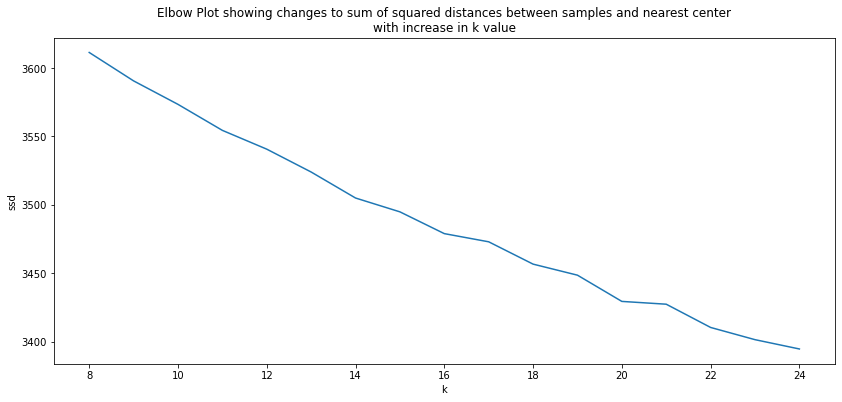

In [269]:
plt.figure(figsize=(14, 6))
plt.plot(range(8, 25), inertias)
plt.title("""Elbow Plot showing changes to sum of squared distances between samples and nearest center
with increase in k value""")
plt.xlabel('k')
plt.ylabel("ssd")
plt.show()

`The elbow plot above does not give us a definitive value for what k should be. To get more insights into an appropriate k value, we will combine it with silhouette scores.`

In [270]:
sil_scores = [silhouette_score(vectorized_reviews, km.predict(vectorized_reviews)) for km in kms]

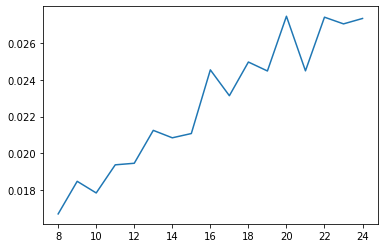

In [271]:
plt.plot(range(8, 25), sil_scores)
plt.show()

`From the elnbow plot and silhouette scores, we will chose k=20`

In [272]:
km20 = kms[12]
km20

KMeans(n_clusters=20, random_state=0)

In [273]:
km20.cluster_centers_.shape
#There are 20 cluster centers
#Each center is an array of length 2240

(20, 2240)

In [274]:
top_features = []

for center in km20.cluster_centers_:
    top15 = center.argsort()[-1:-16:-1]
    top_features.append(top15)
        
        


In [275]:
top_words = []
all_words= np.array(reduced_vectorizer.get_feature_names())
for center in top_features:
    top_words.append(all_words[center])  
    

In [276]:
for i, word_list in zip(range(1, 21), top_words):
    print(i, '\t', word_list )
#Each array below contains the top words in each cluster.
#We can get a clear picture about certain topicsin each cluster of words - for example:
#cluster #1 seems to be about kids ejoying using the tablet for entertainment
#cluster #2 seems to be about using the tablet fir work or educational purposes
#custer #11 seems to talk about the tablet being value for money
#cluster 14 seems to be about buying a tablet as a gift for someone.
#cluster 15 - the use of alexa to play music
#cluster 19 - battery life


1 	 ['kid' 'love' 'use' 'tablet' 'game' 'app' 'buy' 'entertain' 'lot' 'play'
 'get' 'grandson' 'enjoy' 'keep' 'video']
2 	 ['app' 'download' 'use' 'amazon' 'tablet' 'work' 'store' 'buy' 'need'
 'lot' 'love' 'get' 'play' 'learn' 'child']
3 	 ['love' 'buy' 'year' 'tablet' 'grandson' 'granddaughter' 'fire' 'game'
 'use' 'purchase' 'niece' 'mom' 'play' 'age' 'birthday']
4 	 ['buy' 'purchase' 'time' 'screen' 'love' 'tablet' 'need' 'device' 'set'
 'make' 'play' 'child' 'game' 'look' 'recommend']
5 	 ['book' 'read' 'love' 'game' 'kindle' 'use' 'buy' 'need' 'screen'
 'purchase' 'device' 'watch' 'play' 'take' 'carry']
6 	 ['son' 'love' 'buy' 'year' 'game' 'use' 'gift' 'play' 'get' 'purchase'
 'lot' 'learn' 'tablet' 'work' 'enjoy']
7 	 ['work' 'use' 'tablet' 'screen' 'issue' 'buy' 'sound' 'need' 'speaker'
 'video' 'get' 'game' 'download' 'set' 'look']
8 	 ['version' 'kindle' 'love' 'fire' 'light' 'time' 'upgrade' 'purchase'
 'update' 'improvement' 'camera' 'replace' 'video' 'disappoint' 'think']

### Topic Modeling

For topic modeling we will use the gensim library 

In [277]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
import gensim
import pyLDAvis
import pyLDAvis.gensim_models

In [278]:
def tokenizer_and_feature_reducer(doc, allowed_tags=['NOUN', 'VERB']):
    spacy_doc = spacy_nlp_model(doc)
    tokens  = [word.lemma_ for word in spacy_doc if word.pos_ in allowed_tags]
    
    return tokens



In [279]:
cleaned_reviews.head()

0    purchase black fridaypro great price even sale...
1    purchase two amazon echo plus two dot plus fou...
2    average alexa option show thing screen still l...
3                 good product exactly want good price
4    one purchase buy one niece case compare one ho...
Name: reviews.text, dtype: object

In [280]:
tokenized_cleaned_reviews = cleaned_reviews.apply(tokenizer_and_feature_reducer)

In [281]:
tokenized_cleaned_reviews.head()

0    [purchase, price, sale, core, processor, sound...
1    [purchase, amazon, echo, dot, fire, stick, hub...
2          [alexa, option, show, thing, screen, limit]
3                               [product, want, price]
4    [purchase, buy, niece, case, compare, hold, ta...
Name: reviews.text, dtype: object

In [282]:
dct = Dictionary(tokenized_cleaned_reviews)

In [283]:
len(dct)
#There are 2249 unique words in the dictionary

2249

In [284]:
dct.most_common()[:10]
#These are the top 10 most frequently occuring words in the dictionary

[('love', 1228),
 ('use', 1185),
 ('buy', 873),
 ('get', 589),
 ('kindle', 547),
 ('work', 494),
 ('purchase', 440),
 ('product', 440),
 ('read', 415),
 ('echo', 413)]

In [285]:
doc_term_mat = [dct.doc2bow(doc) for doc in tokenized_cleaned_reviews]

In [286]:
for i in doc_term_mat[:2]:
    print(i)

[(0, 1), (1, 1), (2, 1), (3, 2), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)]
[(4, 1), (14, 2), (18, 1), (19, 4), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 2), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1)]


In [287]:
perplexities = []
coherences = []
lda_models = dict()

for num_topics in [7, 9, 11, 13, 20]:
    lda = LdaModel(corpus=doc_term_mat, num_topics=num_topics, id2word=dct, iterations=50, random_state=100, passes=20)
    perplexity = lda.log_perplexity(doc_term_mat)
    coherence_model = CoherenceModel(model=lda, texts=tokenized_cleaned_reviews, dictionary=dct)
    coh = coherence_model.get_coherence()
    perplexities.append(perplexity)
    coherences.append(coh)
    lda_models.update({str(num_topics): lda})
    
#A number of different LDA models will be created.
#These models differ in the number of topics they are trained to identify.
#We will compare the cohenerence of the individual models in order to determine the best model.
#The number of topics was chose using the previously determined silhouette scores as well as 
    #from interpretation of the topics obtained via clustering.

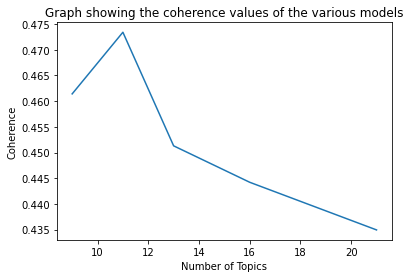

In [288]:
plt.plot([9, 11, 13, 16, 21], coherences)
plt.title("Graph showing the coherence values of the various models")
plt.ylabel('Coherence')
plt.xlabel('Number of Topics')
plt.show()

`From the coherence model, we see that the optimal numer of topics is 11`

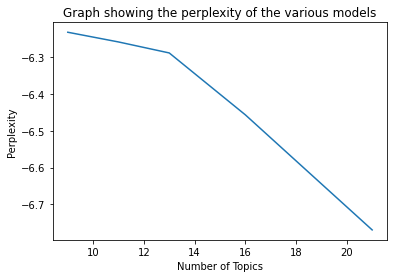

In [296]:
plt.plot([9, 11, 13, 16, 21], perplexities)
plt.title("Graph showing the perplexity of the various models")
plt.ylabel('Perplexity')
plt.xlabel('Number of Topics')
plt.show()

`The plot of the perplexities does not give us much additional information`

In [290]:
lda_models


{'7': <gensim.models.ldamodel.LdaModel at 0x29348828100>,
 '9': <gensim.models.ldamodel.LdaModel at 0x29348c10d60>,
 '11': <gensim.models.ldamodel.LdaModel at 0x29350ac70a0>,
 '13': <gensim.models.ldamodel.LdaModel at 0x2934b620460>,
 '20': <gensim.models.ldamodel.LdaModel at 0x2934bab5f40>}

In [297]:
best_lda_model = lda_models["11"]

best_lda_model.print_topics()
#printed below are the top words for the 11 topics discovered by the LDA algorithm
#Like we saw earlier from clustering, we can see clearly topics emerging.
#Topic 0 - sound and picture quality
#Topic 4- battery life and recommendation for kids
#Topic 5 -ALexa and music
#Topic 8 - gift for family members
#Topic 10 - Reading experience using a kindle 

In [293]:
pyLDAvis.enable_notebook()

In [294]:
vis = pyLDAvis.gensim_models.prepare(best_lda_model, doc_term_mat, dct)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.181721  0.095093       1        1  19.986184
1     -0.012631 -0.254411       2        1  12.952322
6      0.061545 -0.025717       3        1  11.561675
3     -0.018481 -0.042421       4        1  10.872198
8      0.206353  0.102014       5        1  10.415210
0     -0.234735  0.040141       6        1  10.251722
2      0.137960 -0.039104       7        1   8.727011
7     -0.013440 -0.025823       8        1   8.412974
4      0.055149  0.150227       9        1   6.820704, topic_info=        Term         Freq        Total Category  logprob  loglift
54   product   406.000000   406.000000  Default  30.0000  30.0000
110     love  1135.000000  1135.000000  Default  29.0000  29.0000
55       buy   818.000000   818.000000  Default  28.0000  28.0000
46       use  1106.000000  1106.000000  Default  27.0000  27.0000
121   kindle   515.000000   515.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
30        go    13.666496   222.982793   Topic9  -5.2028  -0.1069
51    screen    13.813071   379.242893   Topic9  -5.1921  -0.6274
101     ipad    12.222547    83.835474   Topic9  -5.3144   0.7596
153    video    12.347486   230.996263   Topic9  -5.3043  -0.2437
25       day    12.125525   127.640053   Topic9  -5.3224   0.3313

[615 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
108       1  0.181569  ability
108       2  0.068088  ability
108       4  0.249657  ability
108       6  0.476618  ability
0         7  0.612294   access
...     ...       ...      ...
89        5  0.355901     year
89        7  0.359323     year
89        8  0.085553     year
368       1  0.939977  youtube
368       7  0.046999  youtube

[1117 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 7, 4, 9, 1, 3, 8, 5])

`Displayed above we can see that the LDA algorithm dies a fair job separating the different topics`